In [127]:
# Load packages
import imageio
import matplotlib
import time
import warnings

import matplotlib.pyplot as plt
import matplotlib.image as maimg
import numpy as np
import pandas as pd
import seaborn as sns

from joblib import parallel_backend
from sklearn import cluster, metrics, mixture, model_selection, preprocessing

from FDApy.preprocessing.dim_reduction.fpca import MFPCA, UFPCA
from FDApy.representation.functional_data import DenseFunctionalData
from FDApy.representation.functional_data import IrregularFunctionalData
from FDApy.representation.functional_data import MultivariateFunctionalData
from FDApy.visualization.plot import plot

RECORDING_NUMBER = '00'
VAR = ['x', 'y', 'xVelocity', 'yVelocity', 'xAcceleration', 'yAcceleration']

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

COLORS = ["#377eb8", "#ff7f00", "#4daf4a",
          "#f781bf", "#a65628", "#984ea3",
          "#999999", "#e41a1c", "#dede00"]
custom_palette = sns.set_palette(sns.color_palette(COLORS))

In [54]:
# Utility functions
def read_background(arguments):
    """
    This method reads the background file from rounD data.
    :param arguments: the parsed arguments for the program containing the input path for the background file.
    :return: the background image.
    """
    return imageio.imread(arguments["input_img"])

def get_id(tracks, idx):
    """
    This method returns the information about an particular id.
    :param tracks: a list contaning all tracks as dictionary
    :param idx: the index to return
    :return: a dictionary containing information for a particular idx"""
    l = [d for d in tracks if d['trackId'] == idx]
    return l[0]

def norm(*args):
    """
    Compute the norm of vectors
    :param args: vectors
    :return: norm
    """
    return np.sqrt(np.sum([i**2 for i in args], axis=0))

def cart2pol(cart):
    """
    Transform cartesian to polar coordinates.
    :param cart: Nx2 ndarray
    :return: 2 Nx1 ndarrays
    """
    if cart.shape == (2,):
        cart = np.array([cart])

    x = cart[:, 0]
    y = cart[:, 1]

    th = np.arctan2(y, x)
    r = np.sqrt(np.power(x, 2) + np.power(y, 2))
    return th, r

def pol2cart(th, r):
    """
    Transform polar to cartesian coordinates.
    :param th: Nx1 ndarray
    :param r: Nx1 ndarray
    :return: Nx2 ndarray
    """

    x = np.multiply(r, np.cos(th))
    y = np.multiply(r, np.sin(th))

    cart = np.array([x, y]).transpose()
    return cart

def calculate_rotated_bboxes(center_points_x, center_points_y, length, width, rotation=0):
    """
    Calculate bounding box vertices from centroid, width and length.
    :param centroid: center point of bbox
    :param length: length of bbox
    :param width: width of bbox
    :param rotation: rotation of main bbox axis (along length)
    :return:
    """

    centroid = np.array([center_points_x, center_points_y]).transpose()

    centroid = np.array(centroid)
    if centroid.shape == (2,):
        centroid = np.array([centroid])

    # Preallocate
    data_length = centroid.shape[0]
    rotated_bbox_vertices = np.empty((data_length, 4, 2))

    # Calculate rotated bounding box vertices
    rotated_bbox_vertices[:, 0, 0] = -length / 2
    rotated_bbox_vertices[:, 0, 1] = -width / 2

    rotated_bbox_vertices[:, 1, 0] = length / 2
    rotated_bbox_vertices[:, 1, 1] = -width / 2

    rotated_bbox_vertices[:, 2, 0] = length / 2
    rotated_bbox_vertices[:, 2, 1] = width / 2

    rotated_bbox_vertices[:, 3, 0] = -length / 2
    rotated_bbox_vertices[:, 3, 1] = width / 2

    for i in range(4):
        th, r = cart2pol(rotated_bbox_vertices[:, i, :])
        rotated_bbox_vertices[:, i, :] = pol2cart(th + rotation, r).squeeze()
        rotated_bbox_vertices[:, i, :] = rotated_bbox_vertices[:, i, :] + centroid

    return rotated_bbox_vertices

def plot_trajectories_vel(tracks, idx, id_cluster, trackId, img, meta_tracks, sdf=10, skip_frame=10):
    """
    This methods plots a particular trajectory given an idx.
    :param tracks: a list containing all tracks as dictionary
    :param idx: the indices to plot
    :param img: the background image
    :param sdf: scale down factor (default=10)
    :param skip_frame: number of frames to skip for plotting (defualt=10)
    :return: matplotlib figure
    """
    # Set parameters
    ortho_px_to_meter = meta_tracks['orthoPxToMeter']
    scale_down_factor = sdf
    
    # Define the figure
    fig, axs = plt.subplots(1, 1)
    fig.set_size_inches(18, 8)
    
    j = 0
    for i, c in zip(idx, id_cluster):
        track = get_id(tracks, trackId[i])
        
        if c == 0:
            COLOR_1 = "lightcoral"
            COLOR_2 = "red"
        else:
            COLOR_1 = "cornflowerblue"
            COLOR_2 = "blue"
            
        # Define a dictionary for plotting
        track_vis = {}
        track_vis["xCenterVis"] = track['xCenter'][::skip_frame] / ortho_px_to_meter / scale_down_factor
        track_vis["yCenterVis"] = -track['yCenter'][::skip_frame] / ortho_px_to_meter / scale_down_factor
        track_vis["xVelocityVis"] = track['xVelocity'][::skip_frame]
        track_vis["yVelocityVis"] = -track['yVelocity'][::skip_frame]
        
        p = axs.plot(track_vis["xCenterVis"],
                     track_vis["yCenterVis"],
                     color=COLOR_1, linewidth=5, alpha=0.75)
        for x, y, vx, vy in zip(track_vis["xCenterVis"], track_vis["yCenterVis"],
                                track_vis["xVelocityVis"], track_vis["yVelocityVis"]):
            p = axs.arrow(x, y, 10*vx, 10*vy, color=COLOR_2, head_width=10, head_length=10)
        j = j + 1

    axs.imshow(img)
    axs.set_xlim(300, 1200)
    axs.axis('off')
    fig.tight_layout()
    fig.patch.set_visible(False)
    return fig, axs

def plot_trajectories_acc(tracks, idx, id_cluster, trackId, img, meta_tracks, sdf=10, skip_frame=10):
    """
    This methods plots a particular trajectory given an idx.
    :param tracks: a list containing all tracks as dictionary
    :param idx: the indices to plot
    :param img: the background image
    :param sdf: scale down factor (default=10)
    :param skip_frame: number of frames to skip for plotting (defualt=10)
    :return: matplotlib figure
    """
    # Set parameters
    ortho_px_to_meter = meta_tracks['orthoPxToMeter']
    scale_down_factor = sdf
    
    # Define the figure
    fig, axs = plt.subplots(1, 1)
    fig.set_size_inches(18, 8)
    
    j = 0
    for i, c in zip(idx, id_cluster):
        track = get_id(tracks, trackId[i])

        if c == 0:
            COLOR_1 = "lightcoral"
            COLOR_2 = "red"
        else:
            COLOR_1 = "cornflowerblue"
            COLOR_2 = "blue"
            
        # Define a dictionary for plotting
        track_vis = {}
        track_vis["xCenterVis"] = track['xCenter'][::skip_frame] / ortho_px_to_meter / scale_down_factor
        track_vis["yCenterVis"] = -track['yCenter'][::skip_frame] / ortho_px_to_meter / scale_down_factor
        track_vis["xAccelerationVis"] = track['xAcceleration'][::skip_frame]
        track_vis["yAccelerationVis"] = -track['yAcceleration'][::skip_frame]
        
        q = axs.plot(track_vis["xCenterVis"],
                     track_vis["yCenterVis"],
                     color=COLOR_1, linewidth=5, alpha=0.75)
        for x, y, ax, ay in zip(track_vis["xCenterVis"], track_vis["yCenterVis"],
                                track_vis["xAccelerationVis"], track_vis["yAccelerationVis"]):
            q = axs.arrow(x, y, 10*ax, 10*ay, color=COLOR_2, head_width=10, head_length=10)
        j = j + 1
    
    axs.imshow(img)
    axs.set_xlim(300, 1200)
    axs.axis('off')
    fig.tight_layout()
    fig.patch.set_visible(False)
    return fig, axs

In [3]:
argv = {
    "input_path": f'./data/{RECORDING_NUMBER}_tracks.csv',
    "input_static_path": f'./data/{RECORDING_NUMBER}_tracksMeta.csv',
    "input_meta_path": f'./data/{RECORDING_NUMBER}_recordingMeta.csv',
    "input_img": f'./data/{RECORDING_NUMBER}_background.png'
}

In [4]:
# Load data
tracks = pd.read_pickle(f'./data/tracks_sub.pkl')
info = pd.read_pickle(f'./data/info.pkl')
meta = pd.read_pickle(f'./data/meta.pkl')
data_fd = pd.read_pickle(f'./data/tracks_smooth_fd.pkl')
tree = pd.read_pickle(f'./data/tree.pkl')
results = pd.read_pickle(f'./data/fcubt_results.pkl')
background = read_background(argv)

In [22]:
trackId = [d['trackId'] for d in tracks]

/var/folders/0r/1cdrp_q16sg6kws2yv7ws1p80000gn/T/ipykernel_85095/2685405765.py:112: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 1)


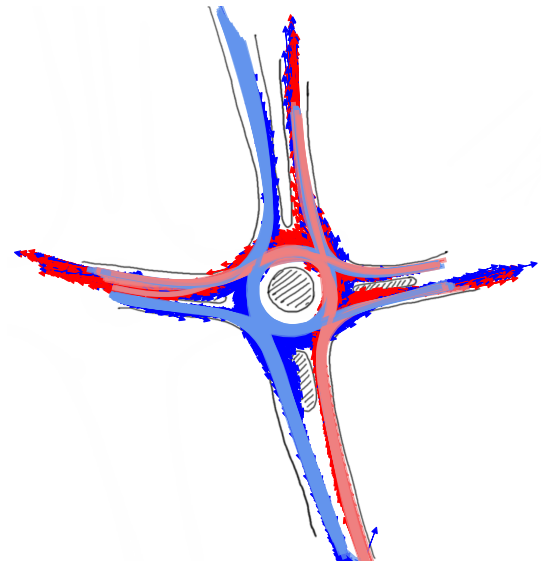

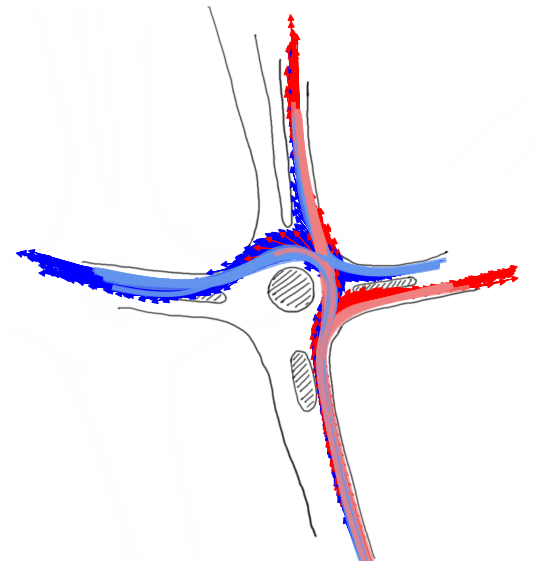

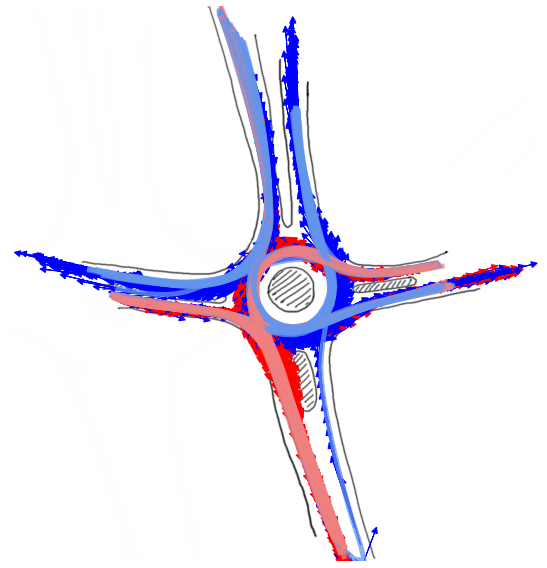

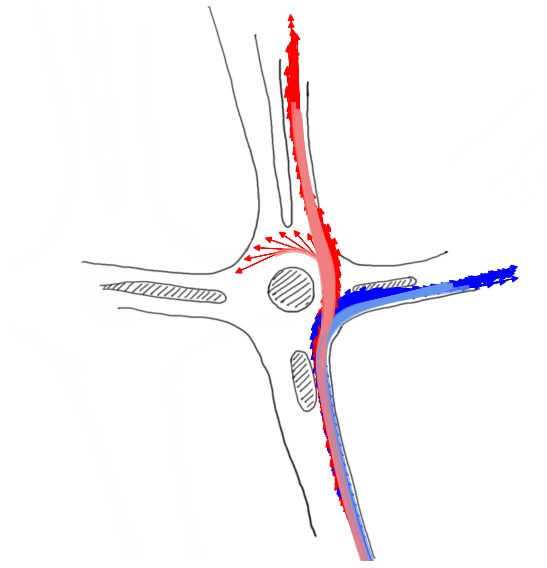

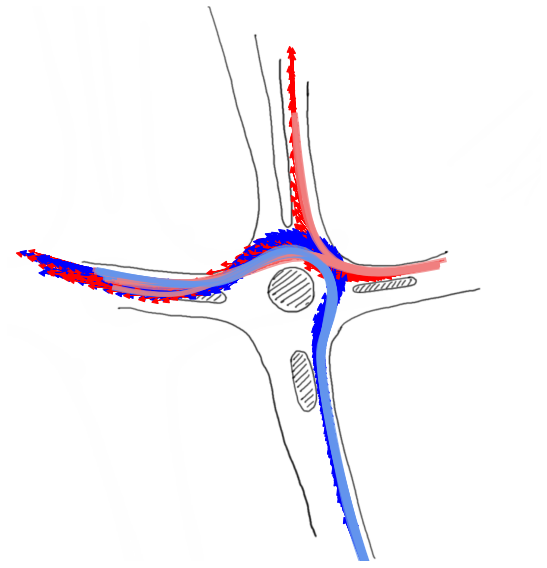

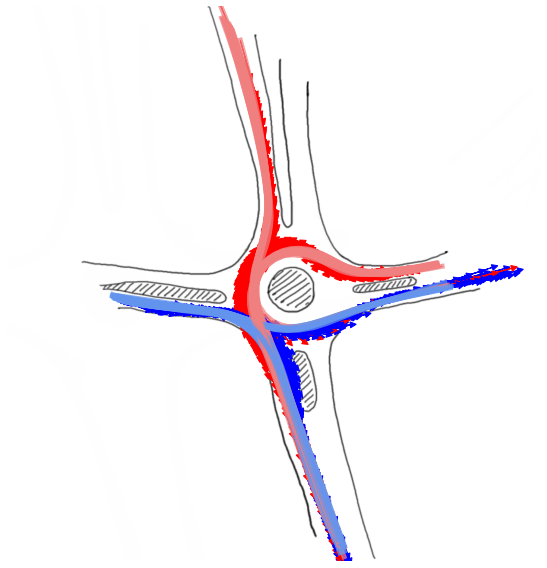

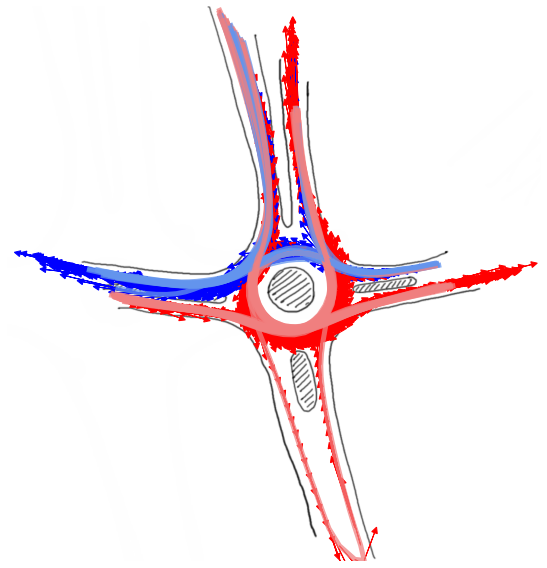

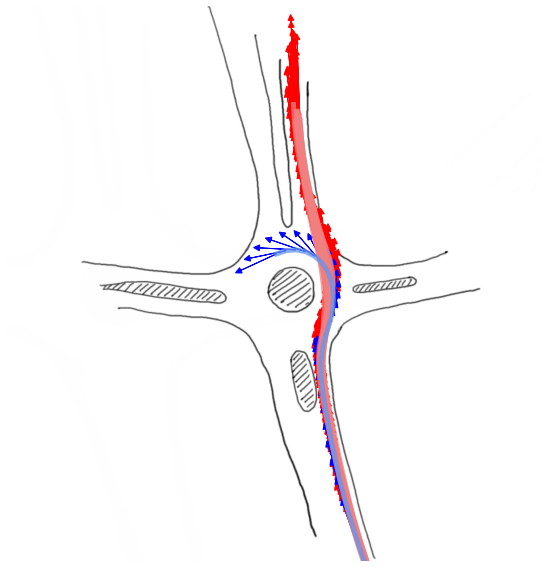

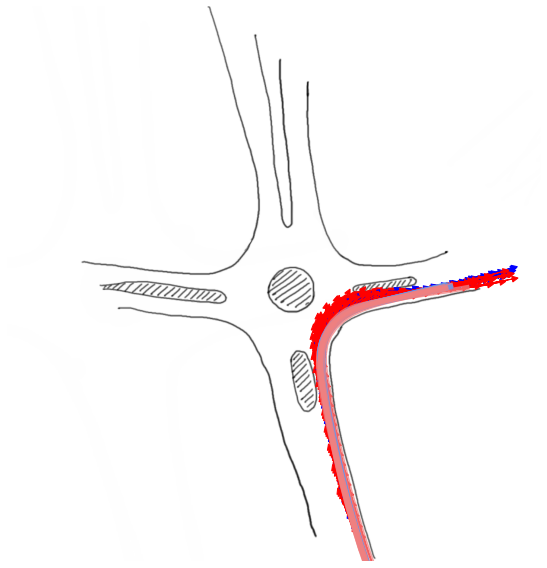

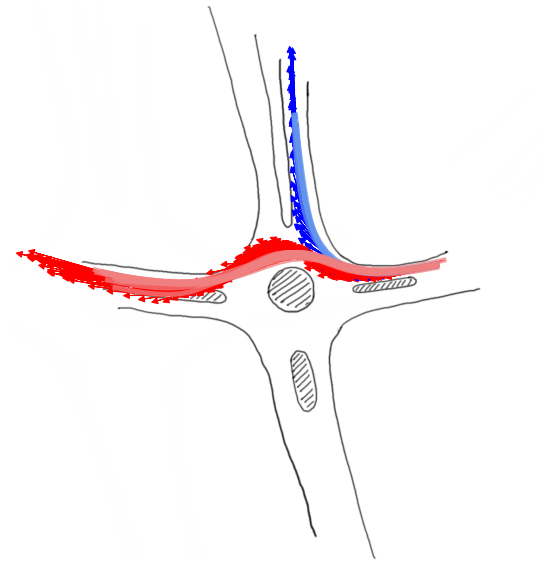

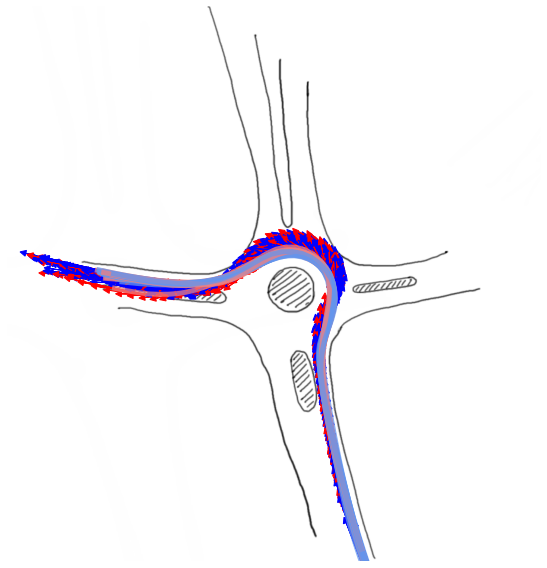

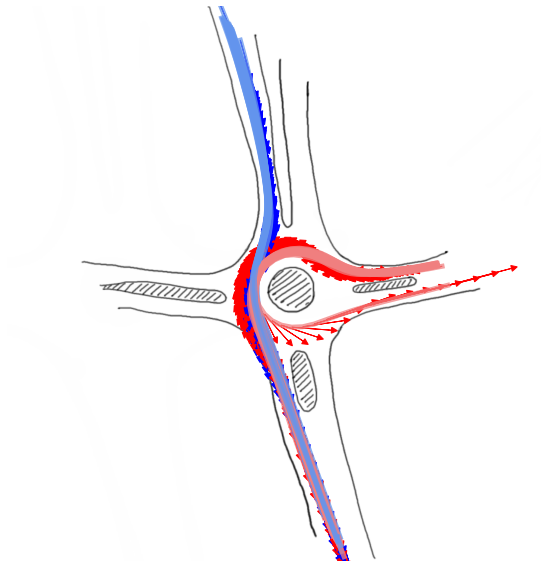

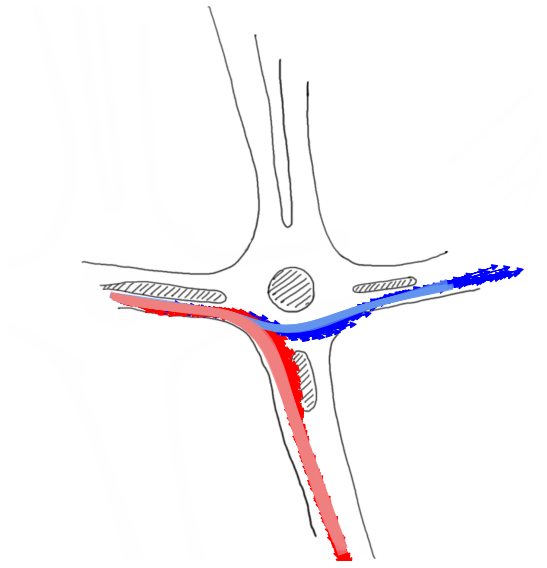

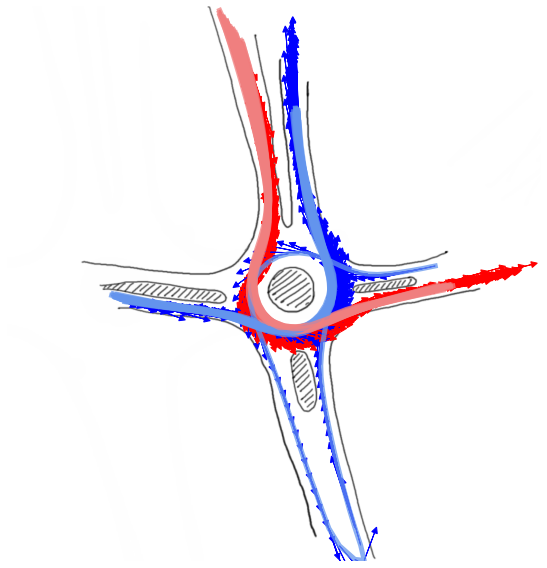

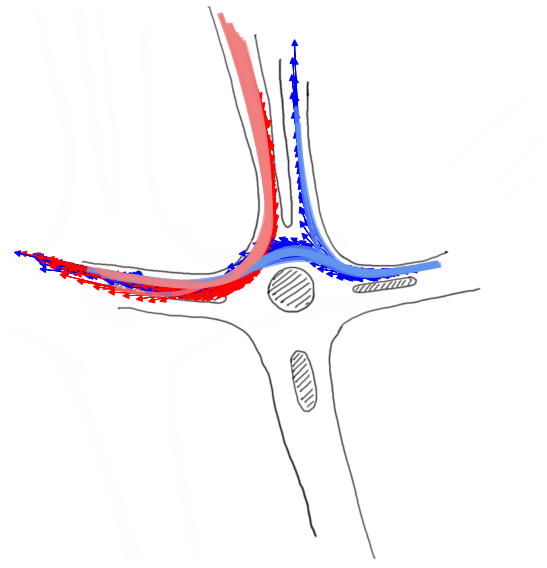

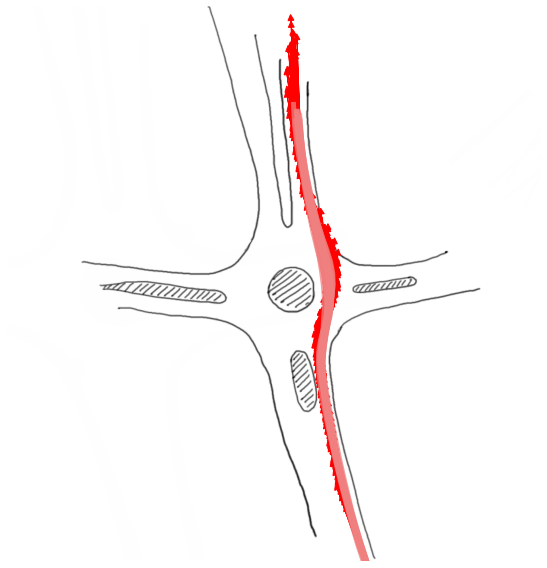

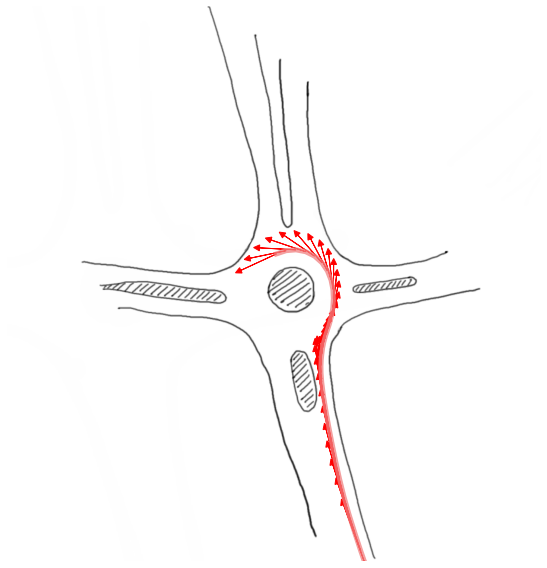

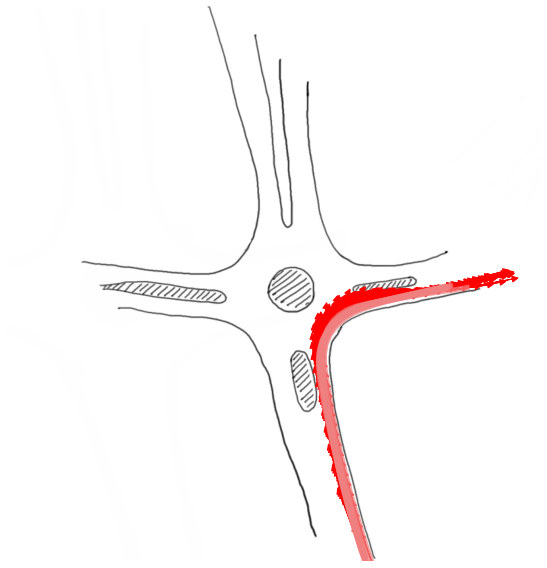

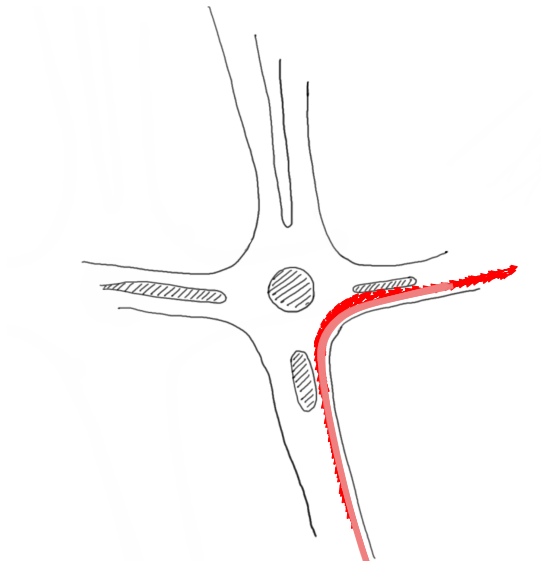

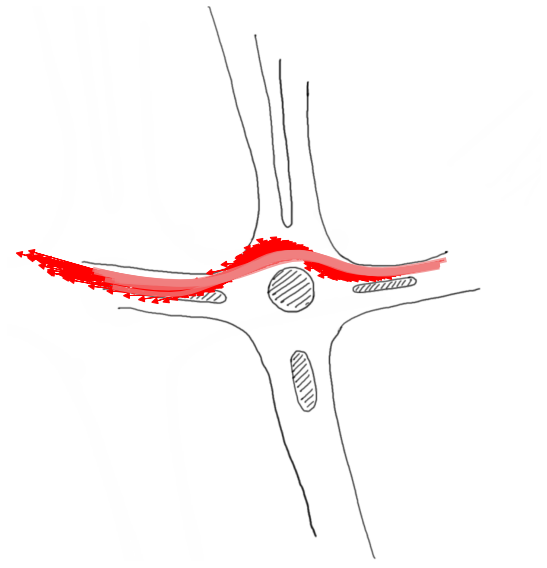

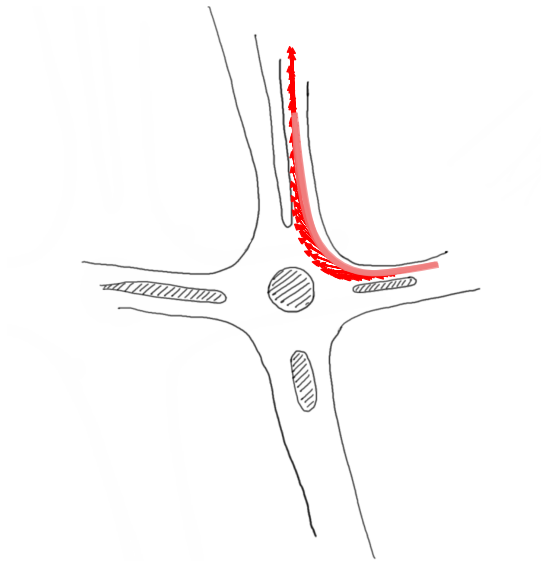

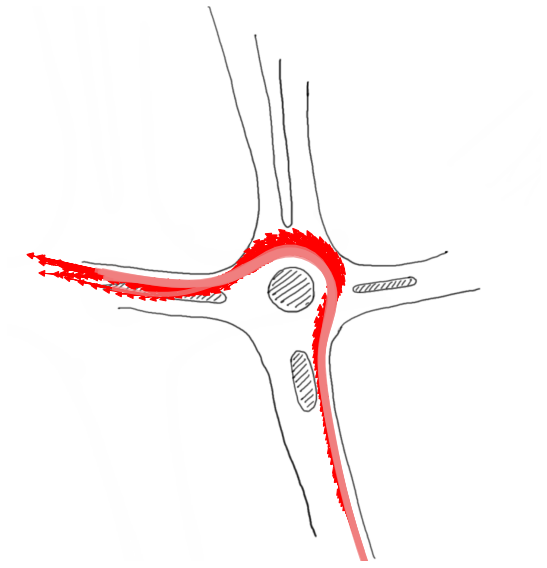

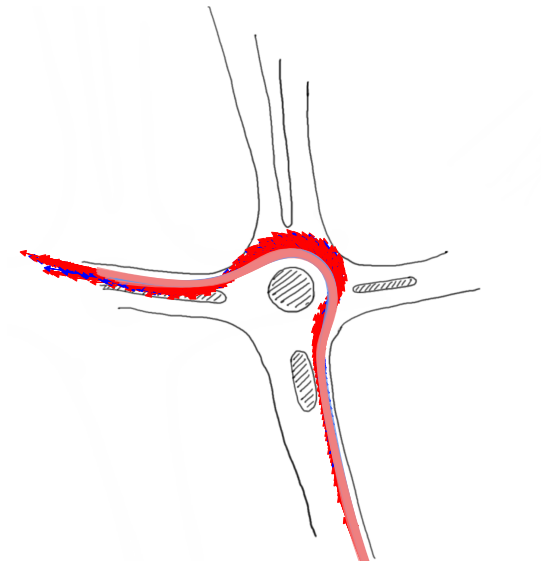

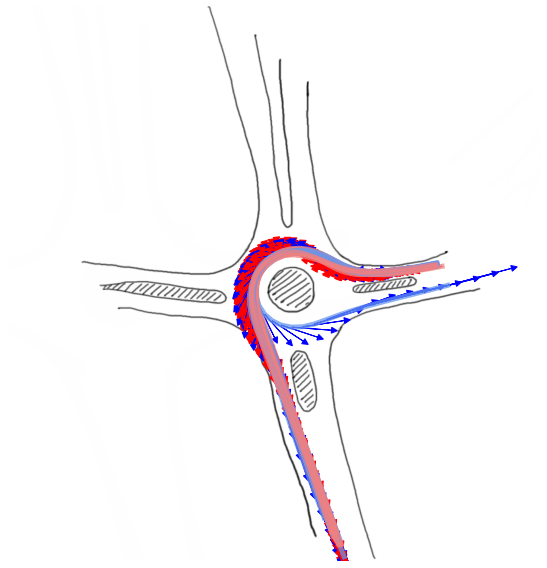

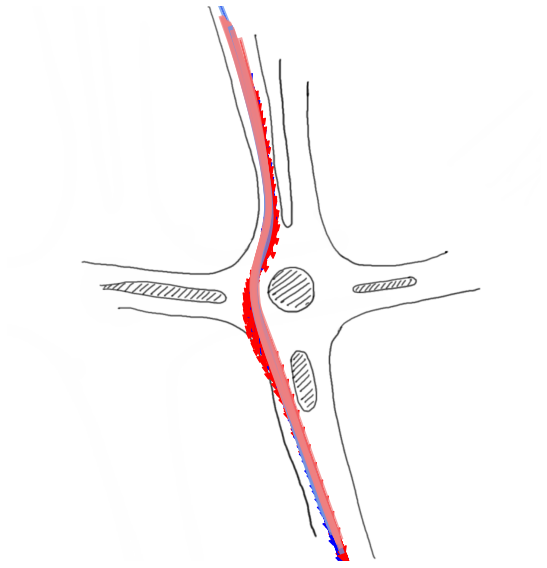

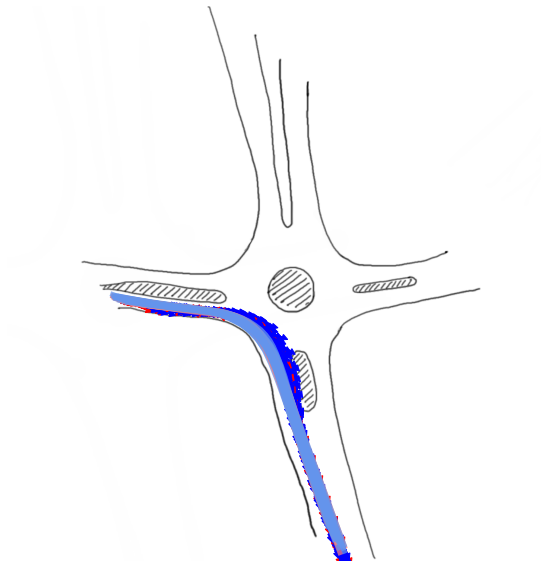

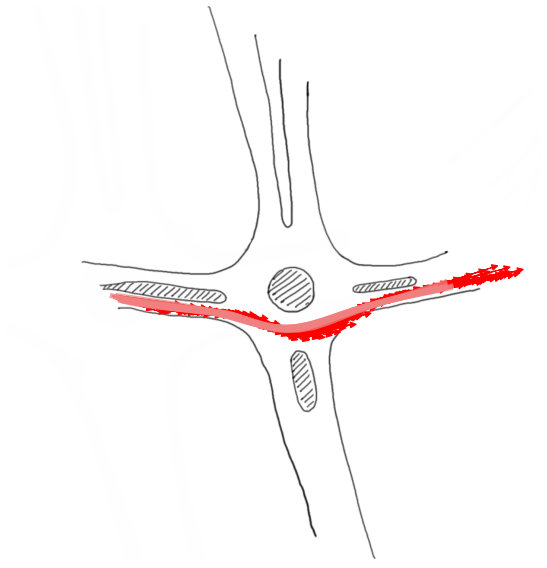

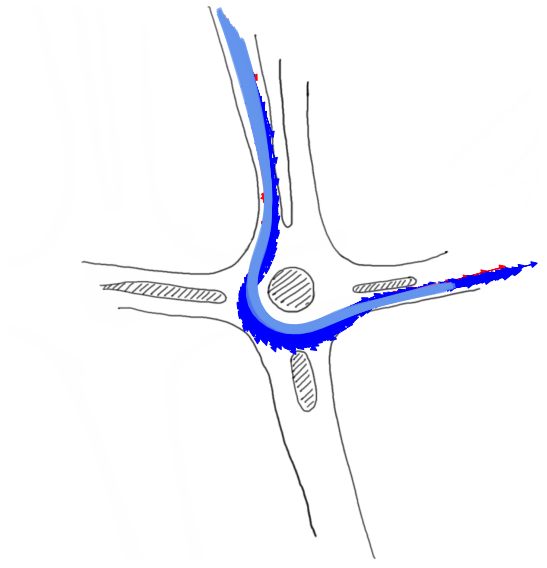

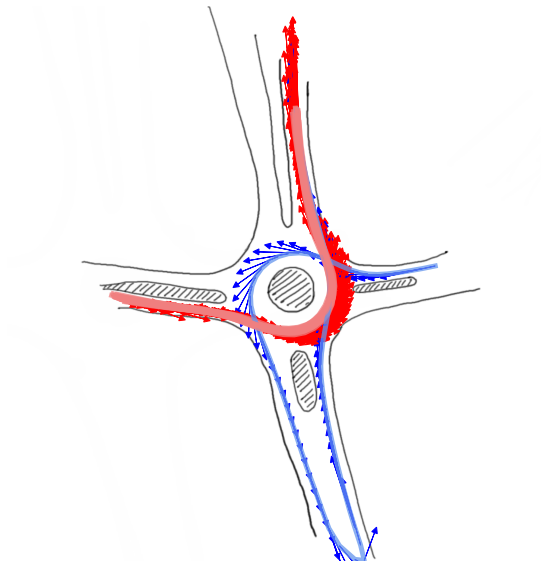

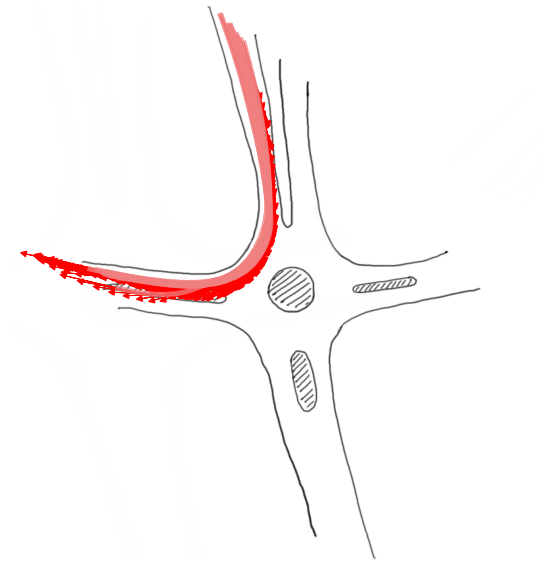

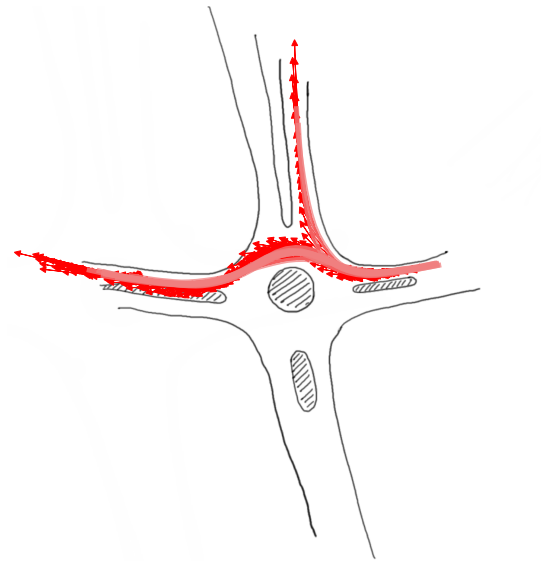

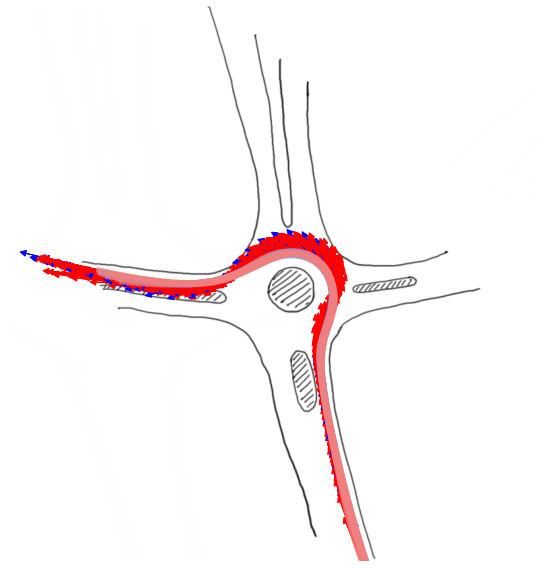

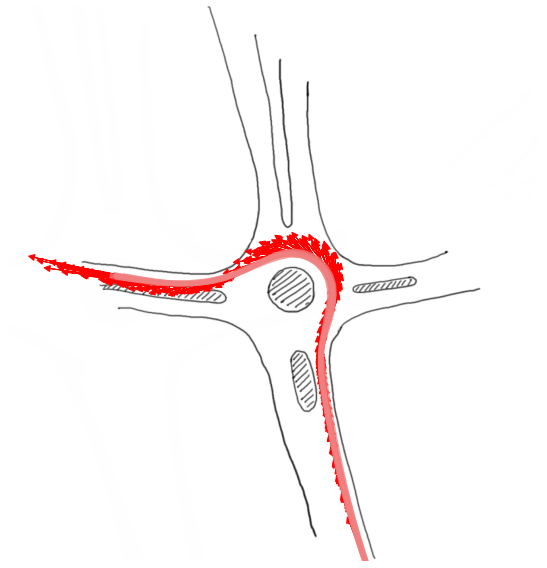

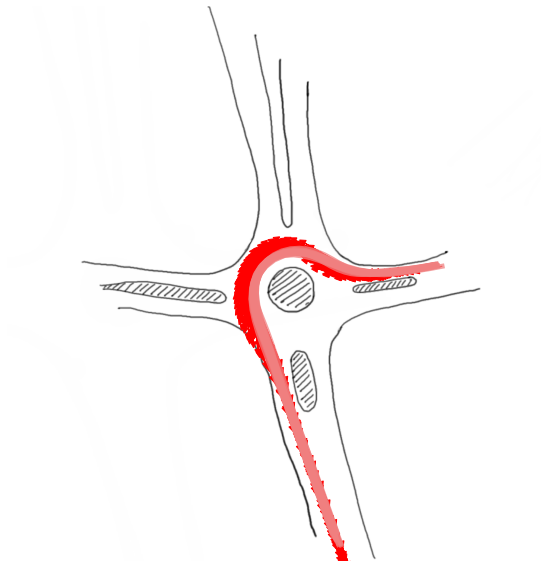

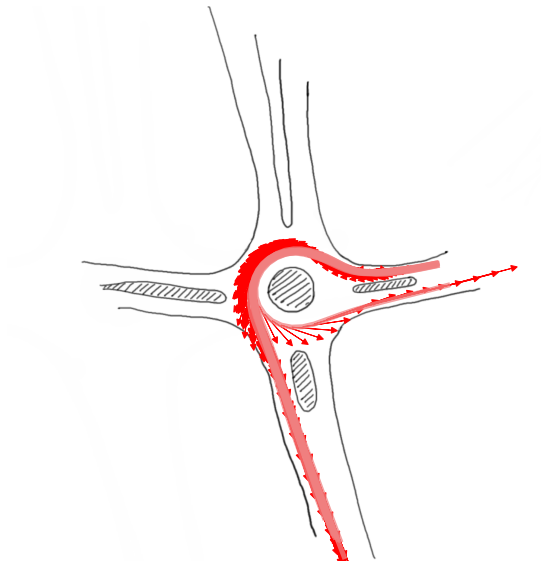

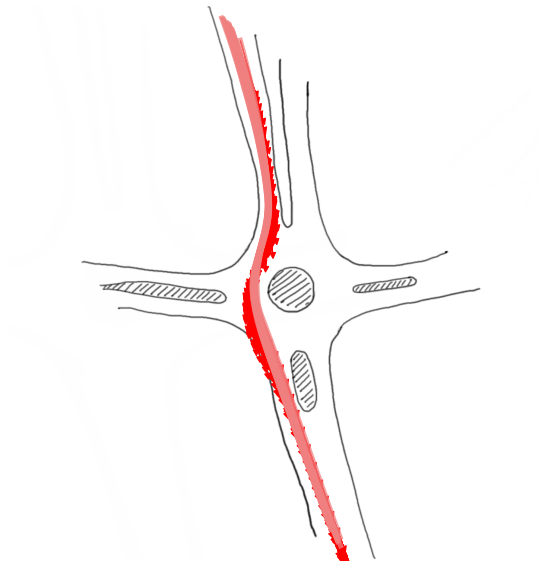

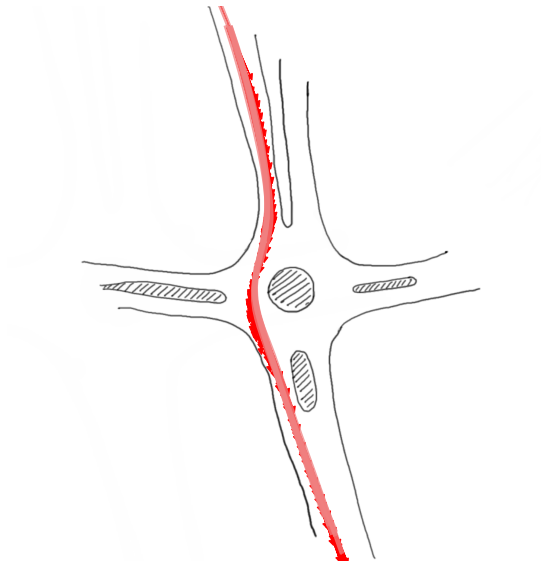

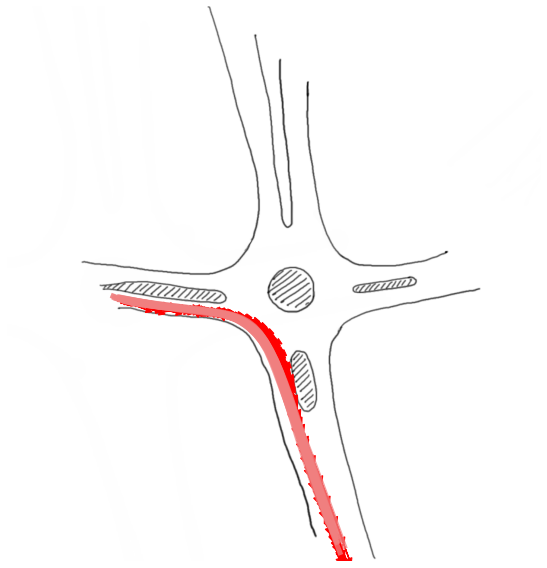

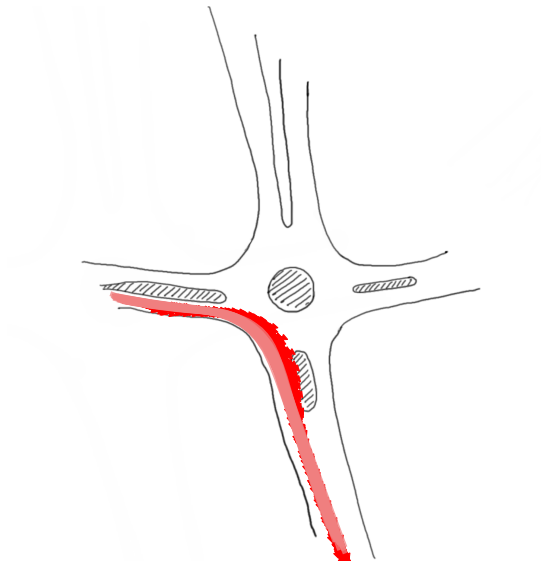

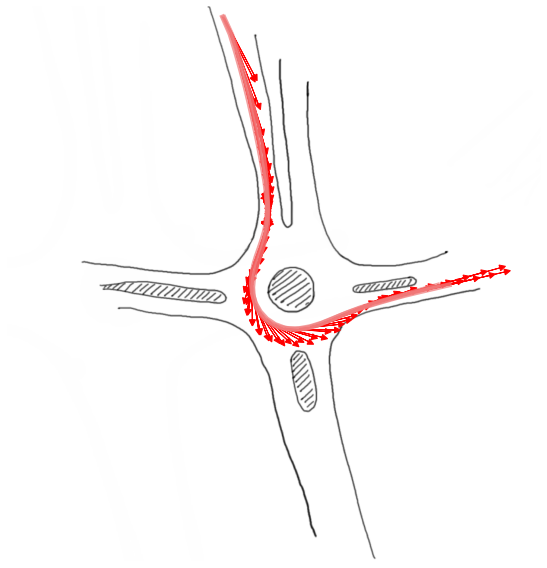

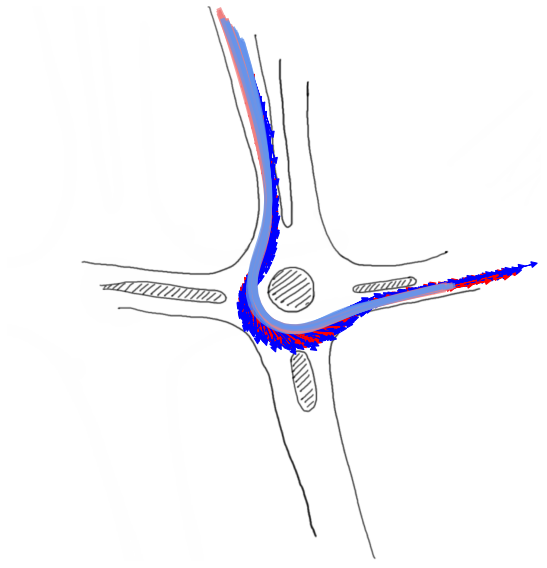

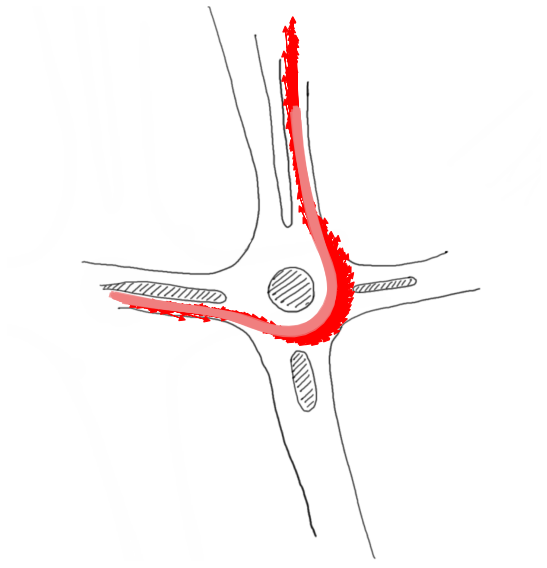

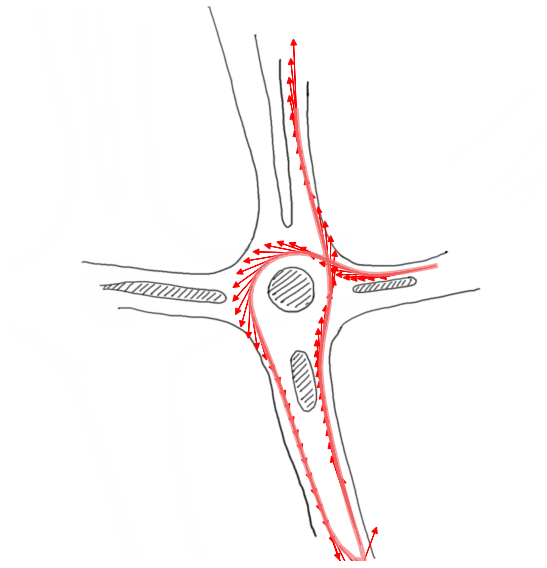

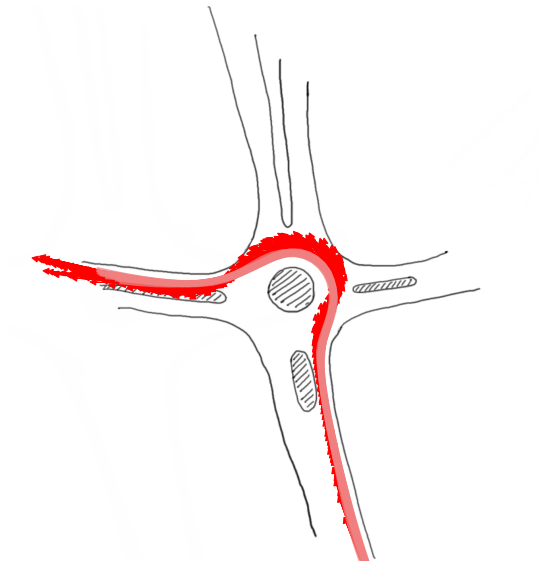

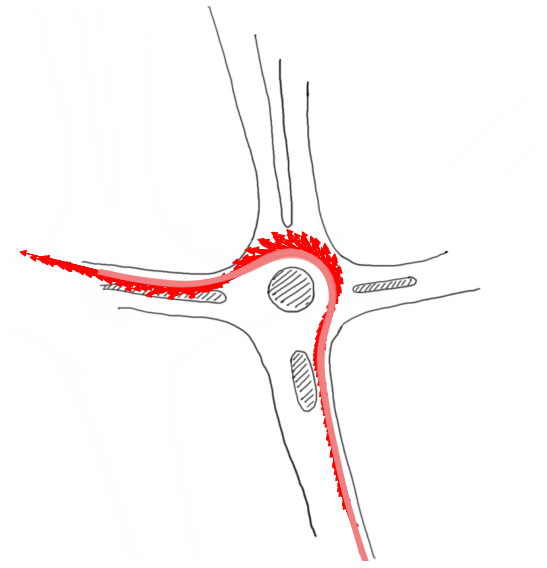

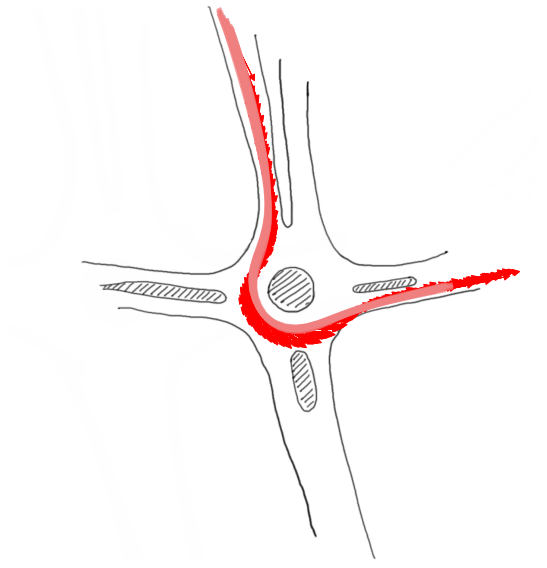

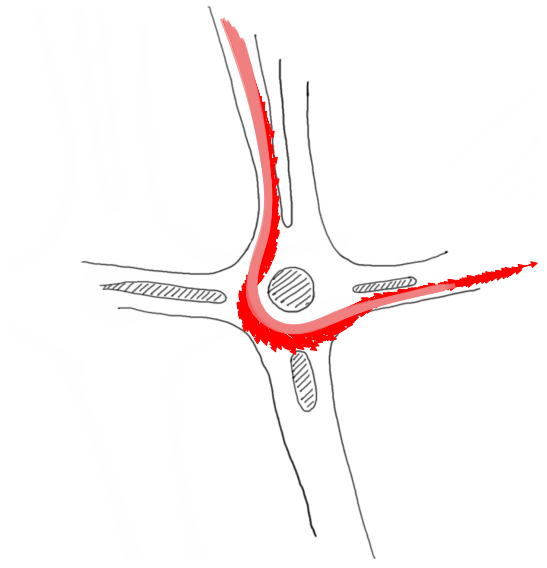

In [53]:
for node in tree.tree:
    _ = plot_trajectories_vel(tracks, node.idx_obs, node.labels, trackId, 
                              background, meta, sdf=10, skip_frame=10)
    plt.savefig(f'./figures/tree/vel/node-{node.identifier}.png', bbox_inches='tight', format='png')

/var/folders/0r/1cdrp_q16sg6kws2yv7ws1p80000gn/T/ipykernel_85095/1994453567.py:163: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1, 1)


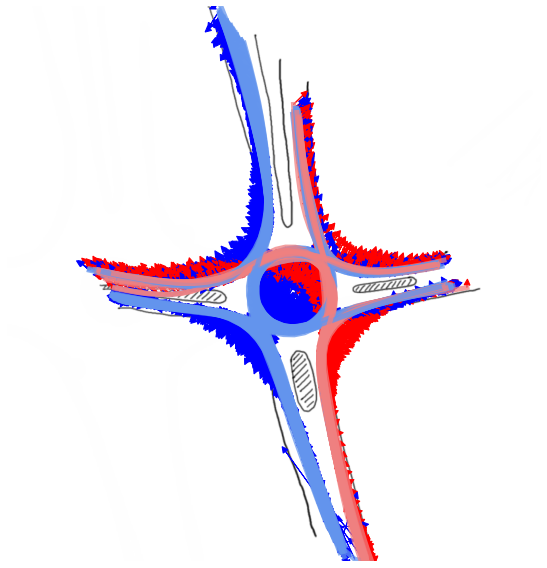

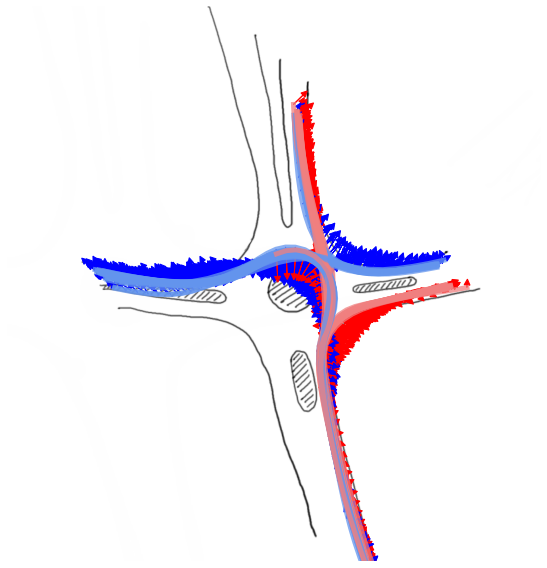

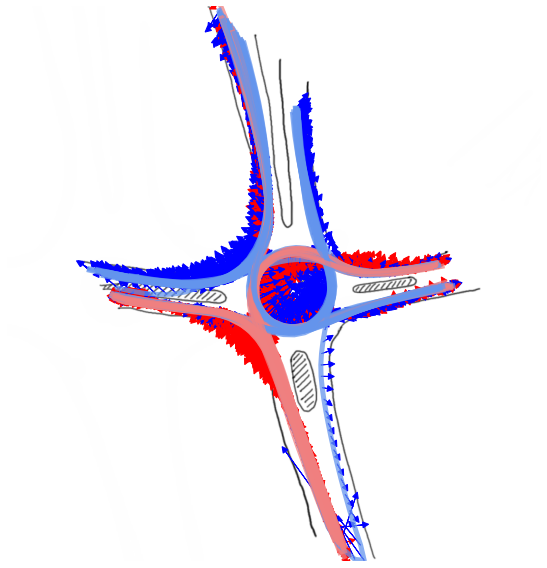

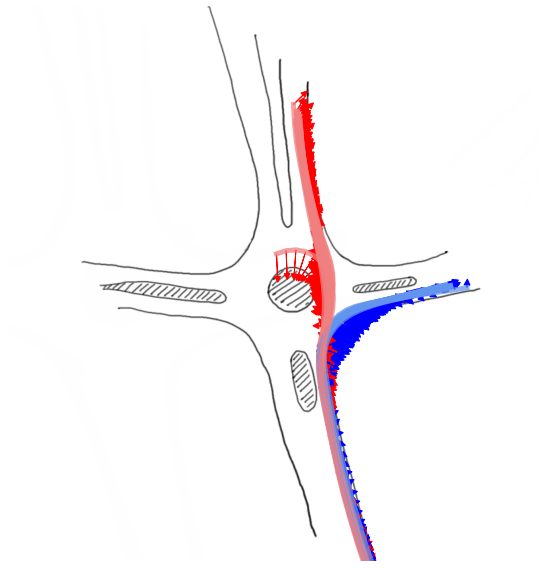

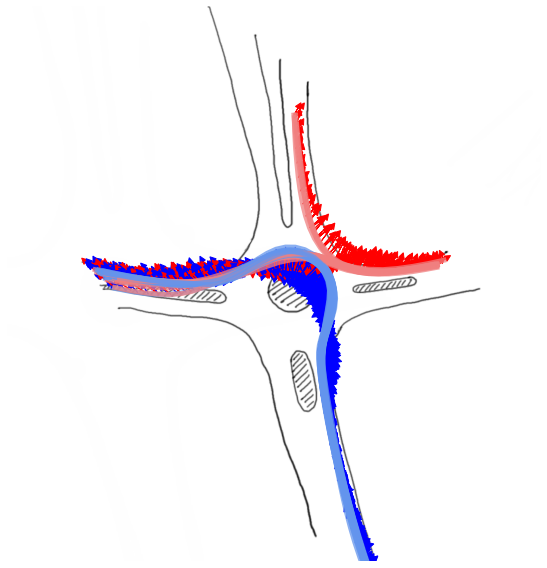

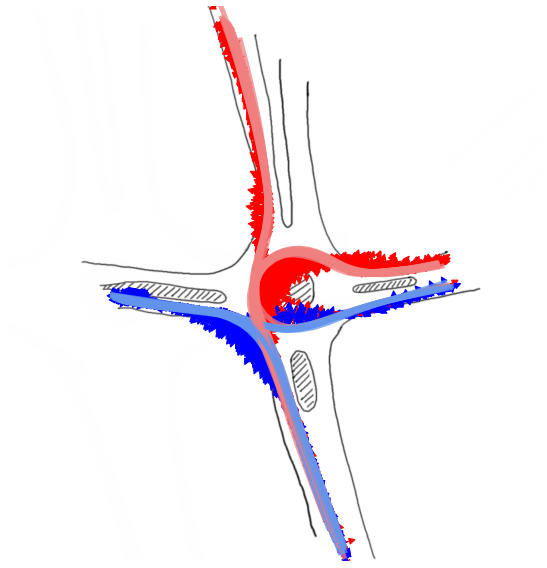

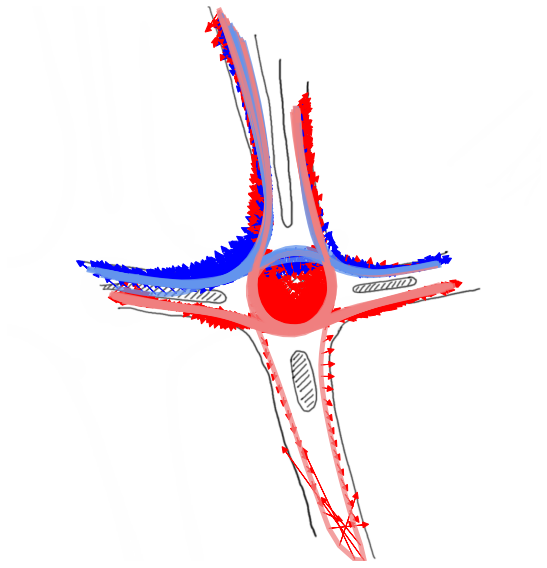

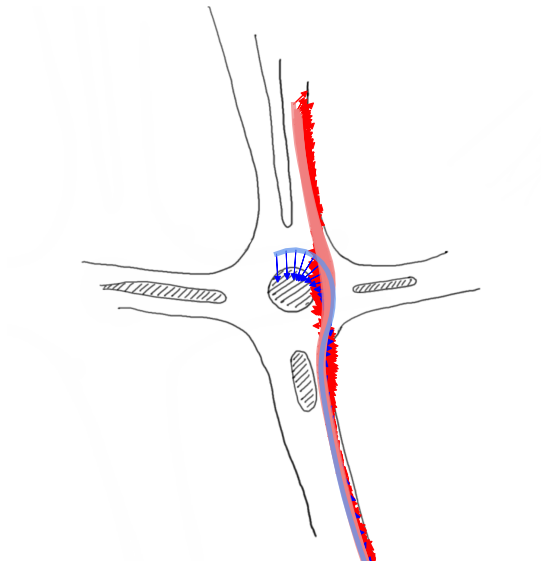

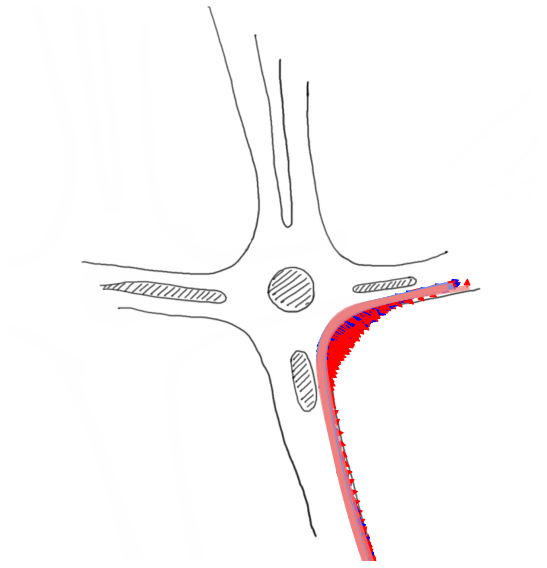

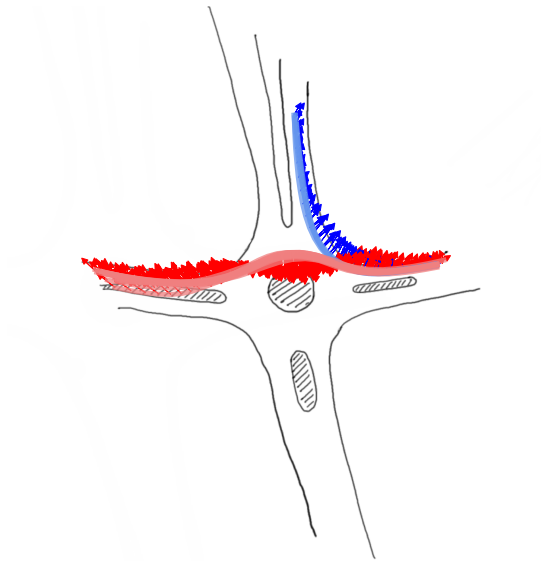

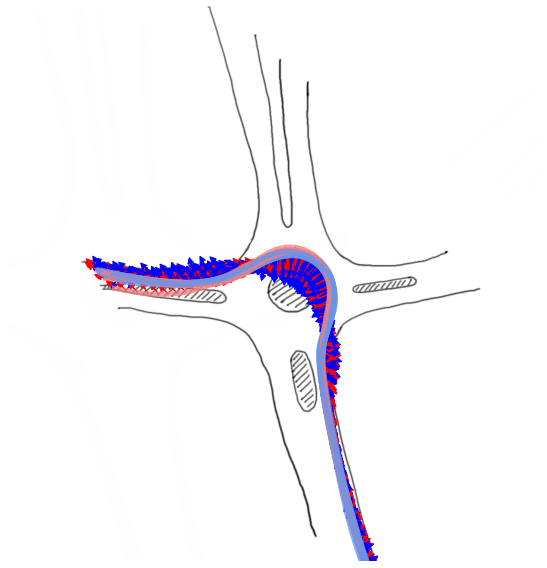

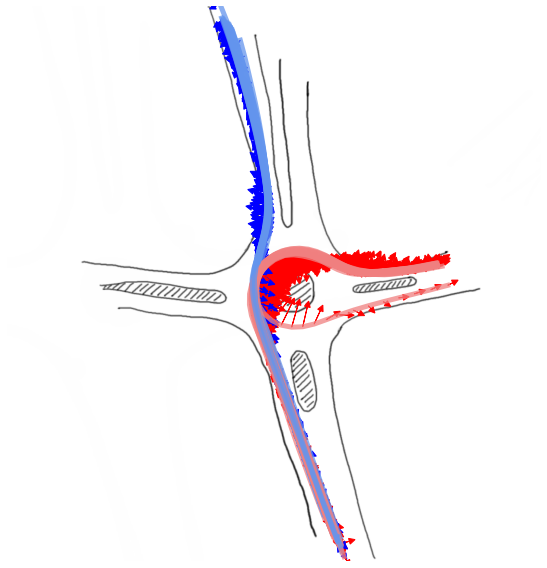

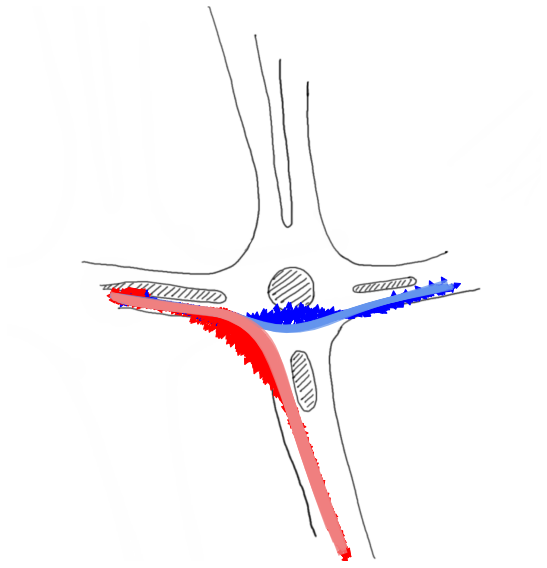

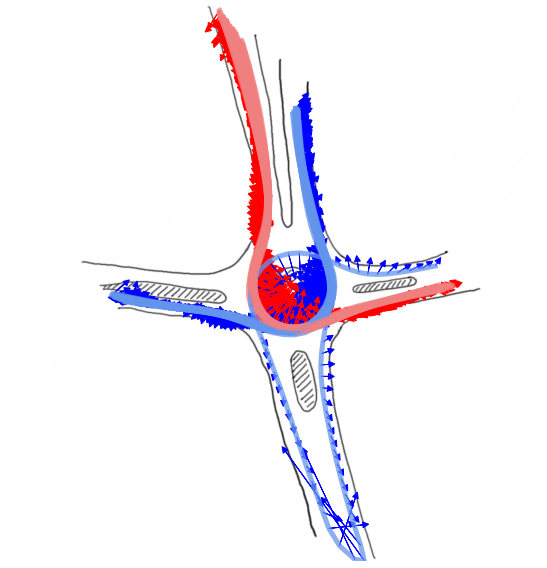

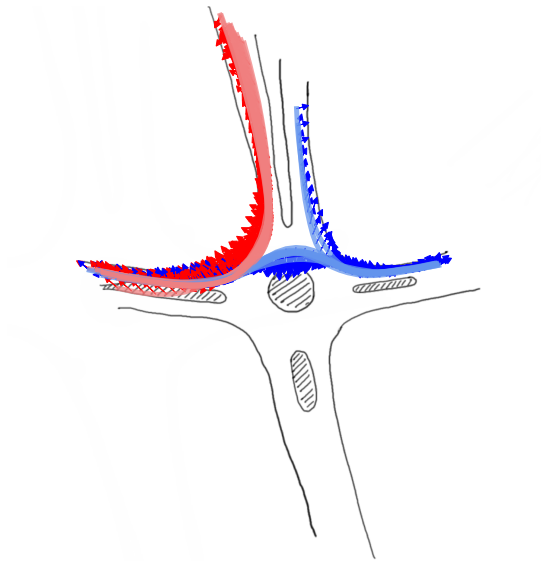

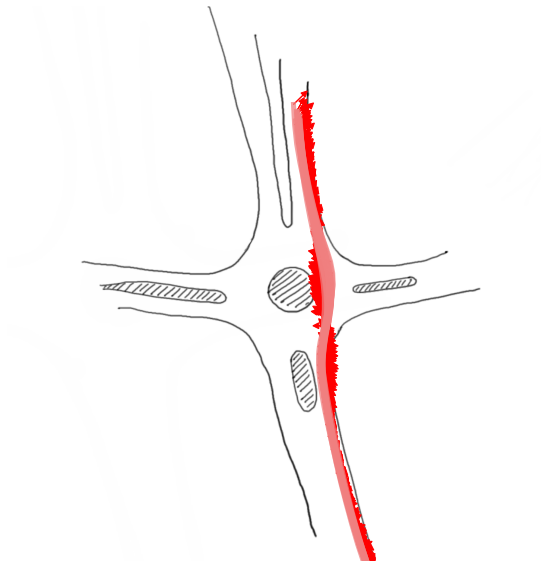

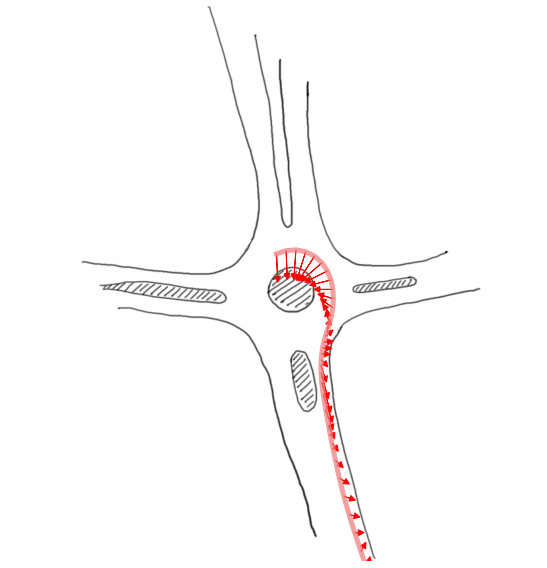

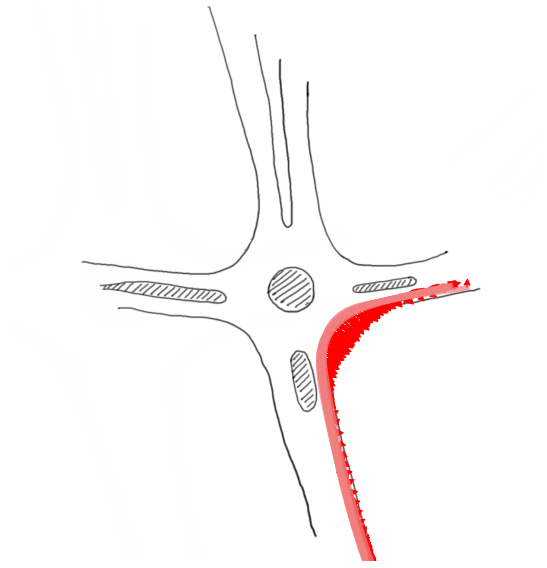

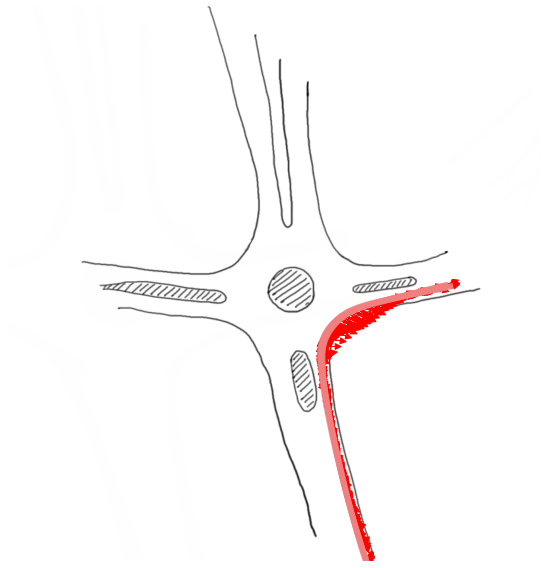

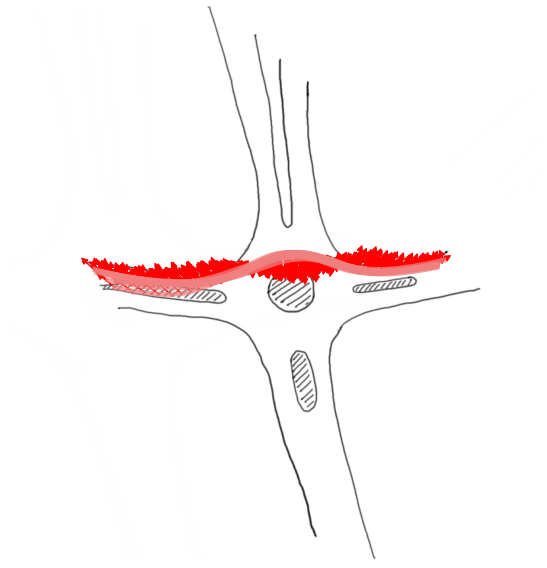

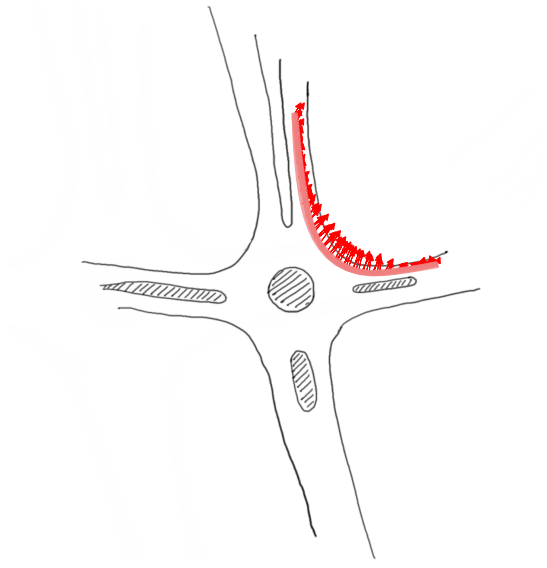

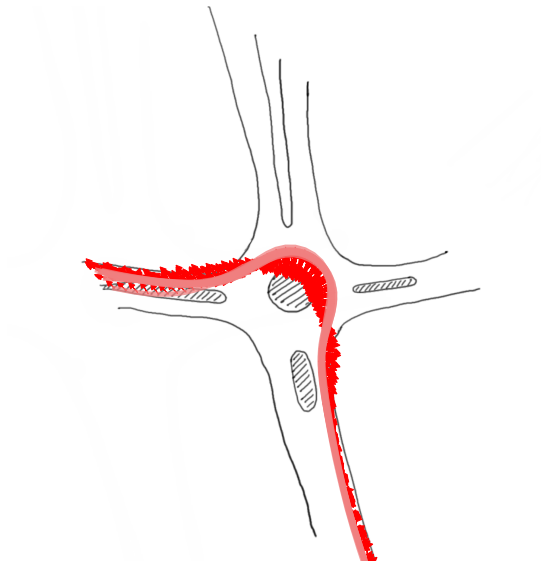

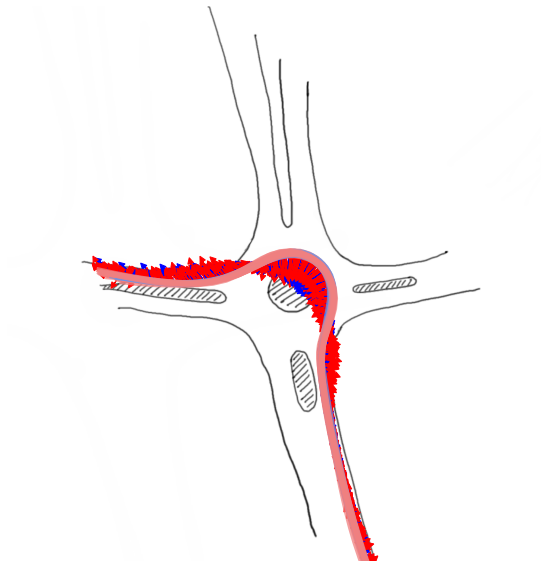

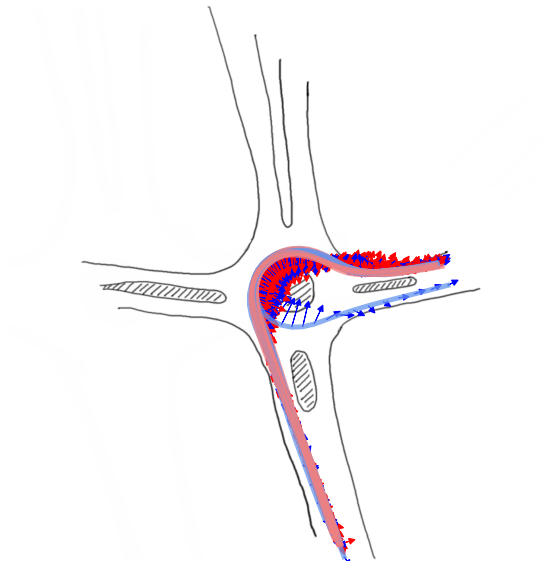

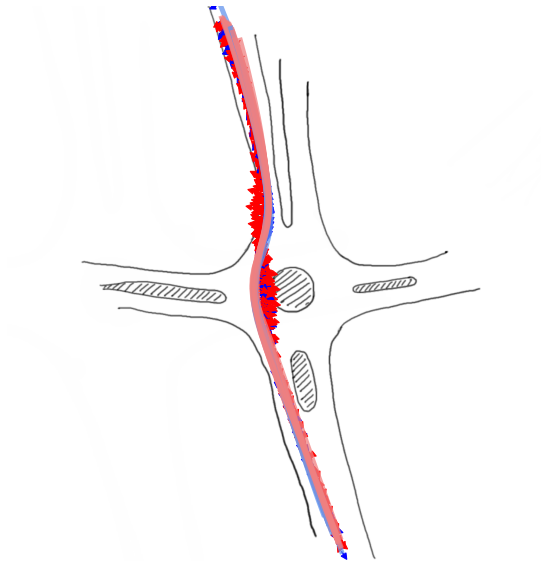

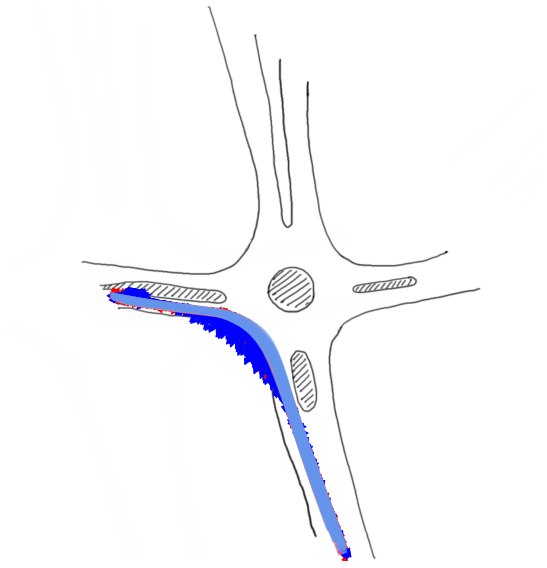

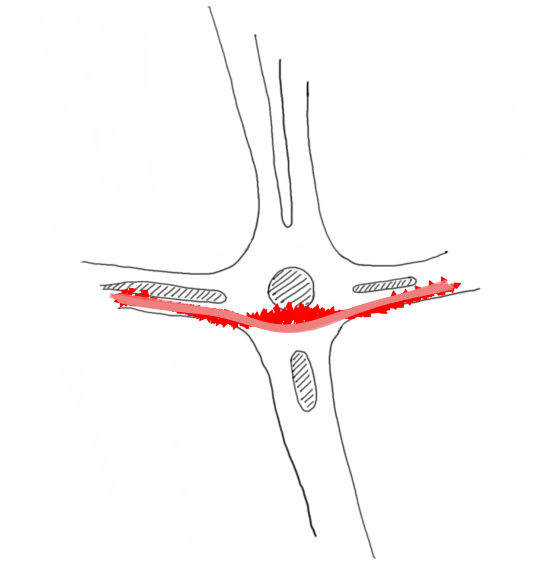

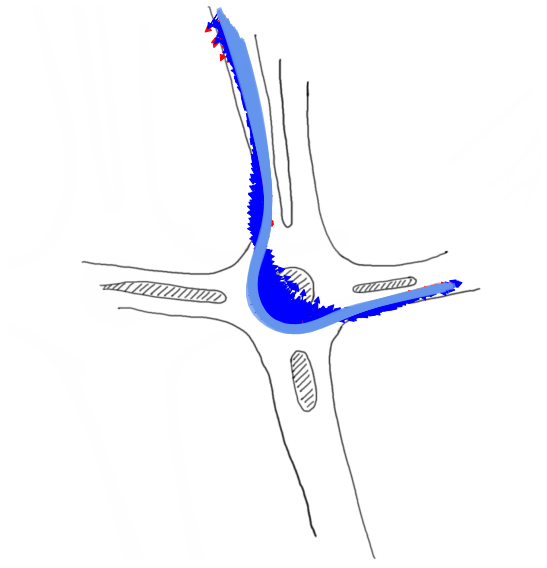

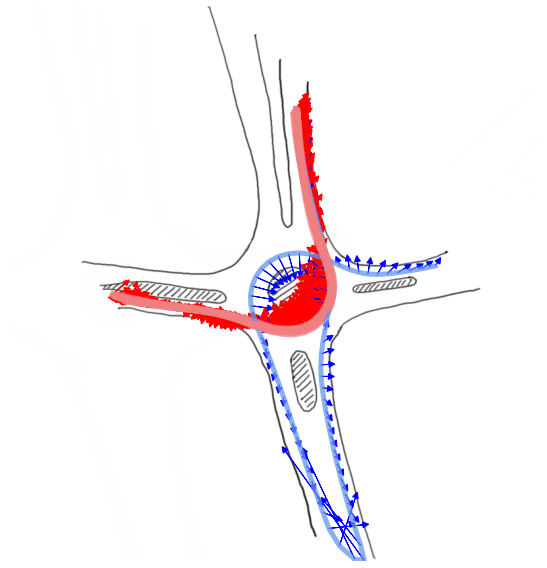

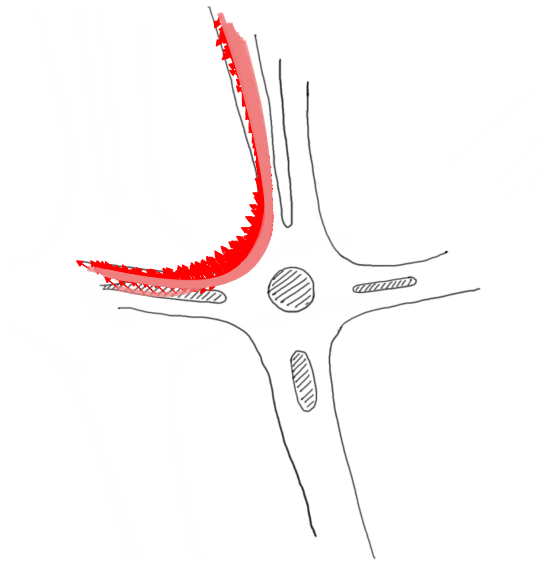

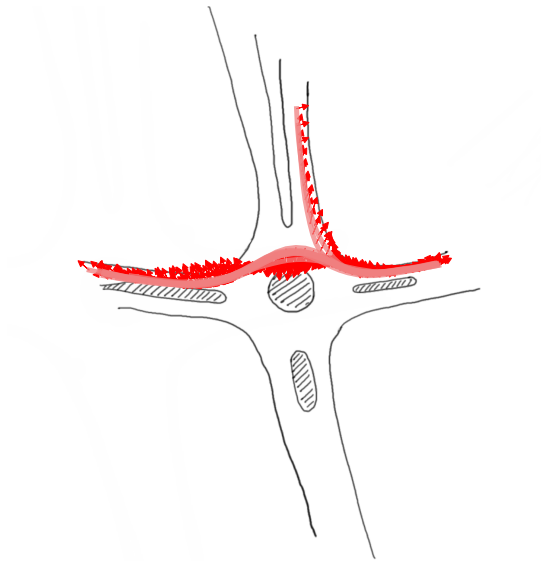

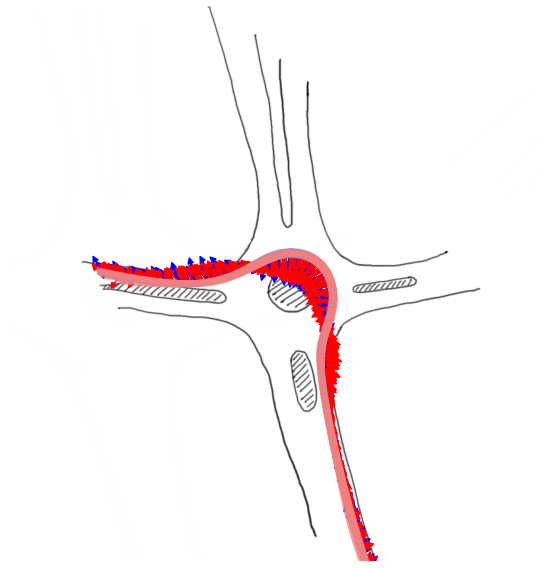

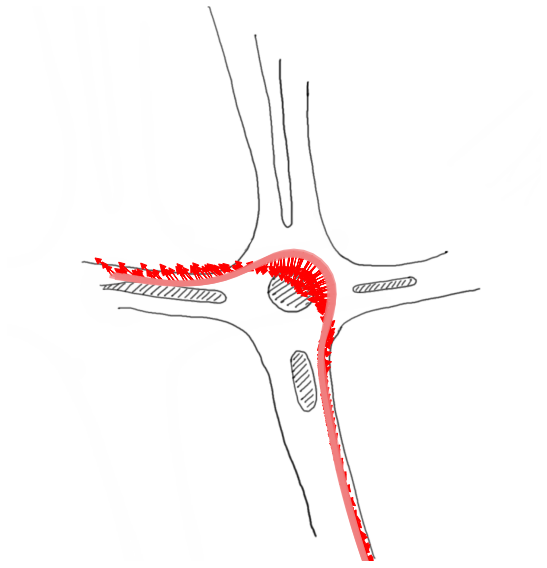

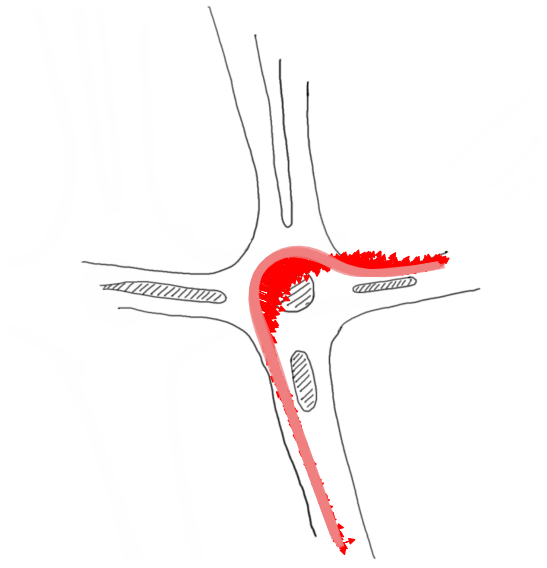

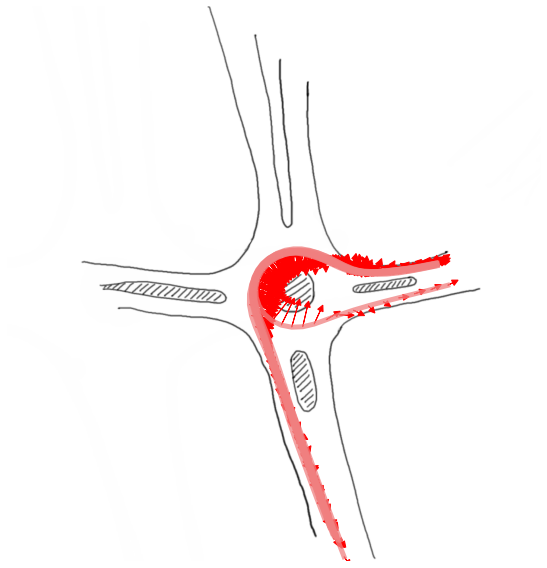

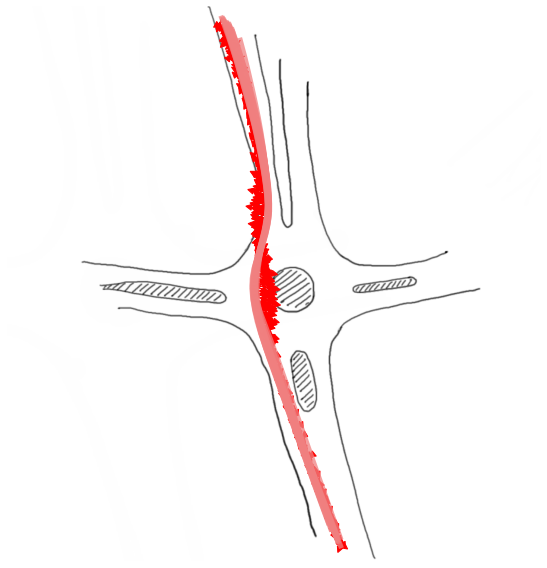

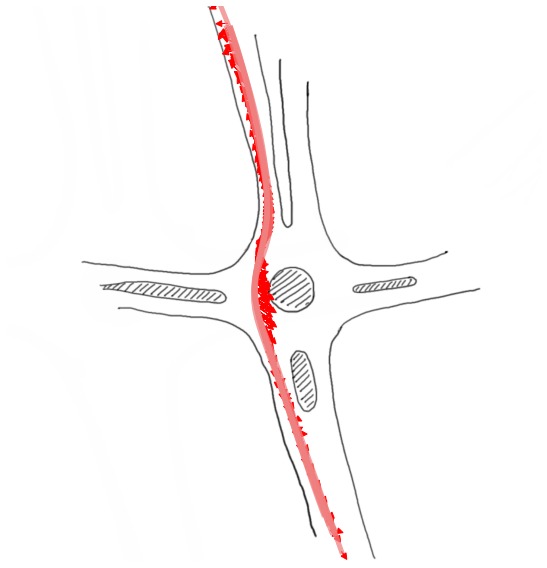

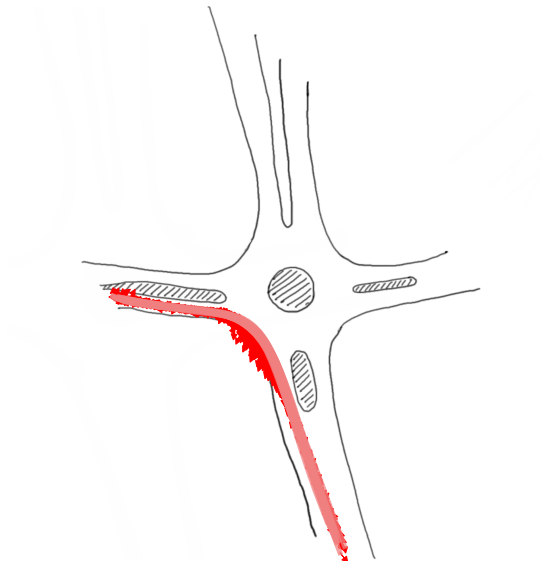

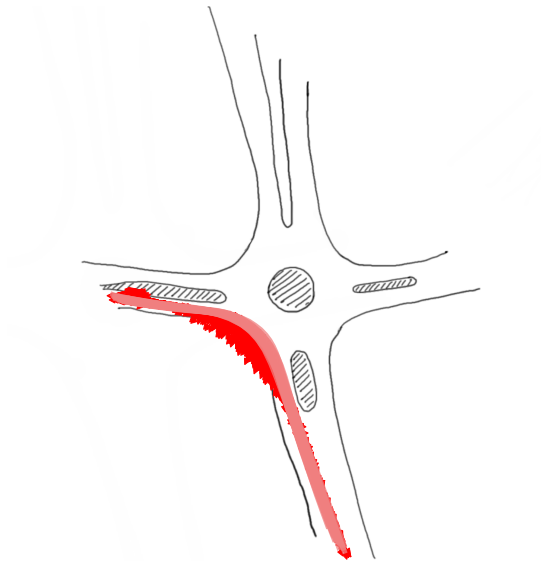

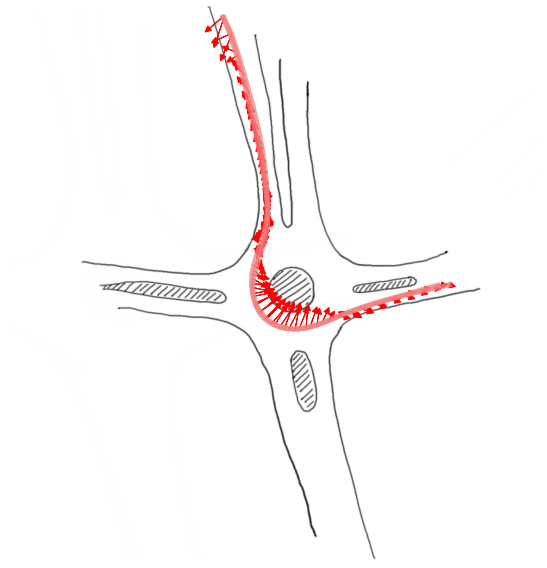

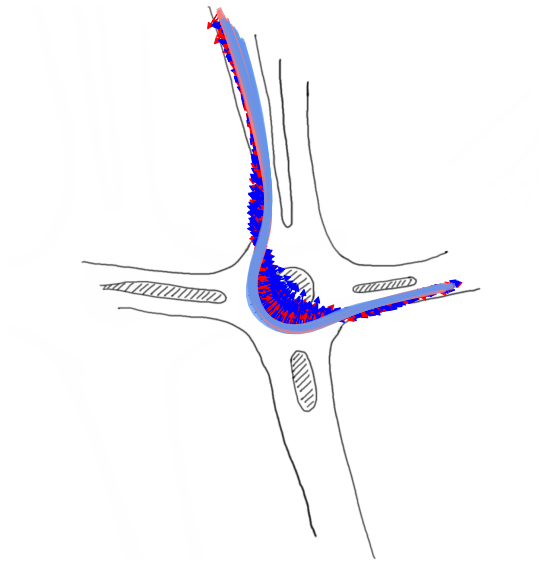

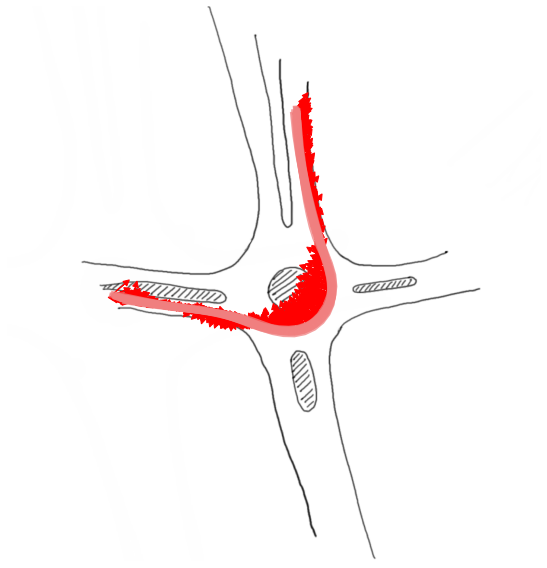

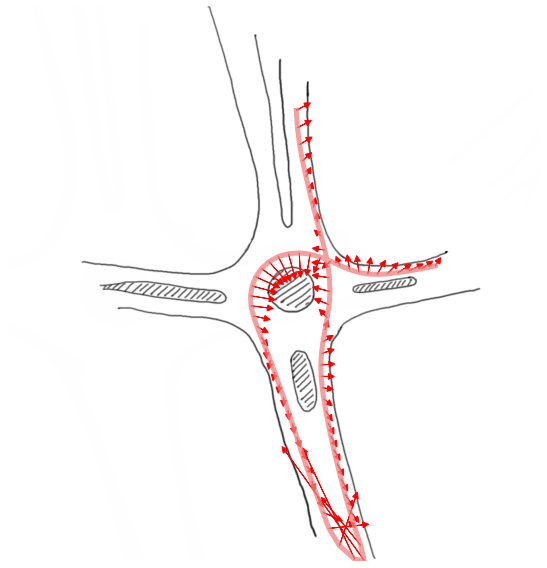

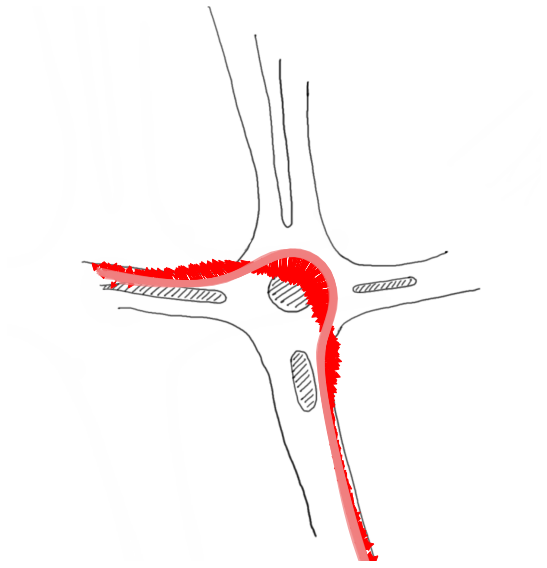

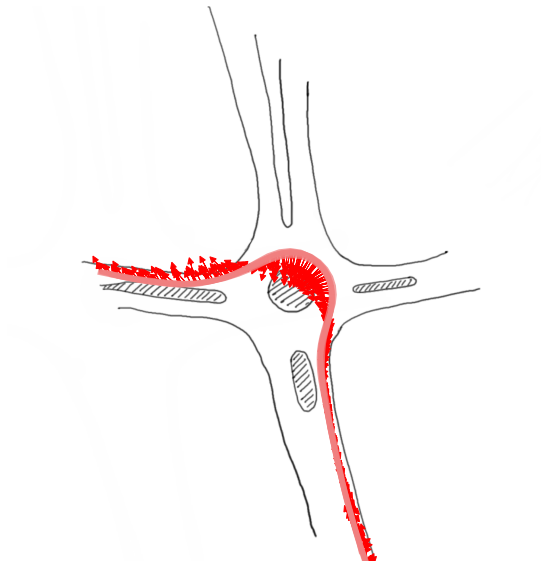

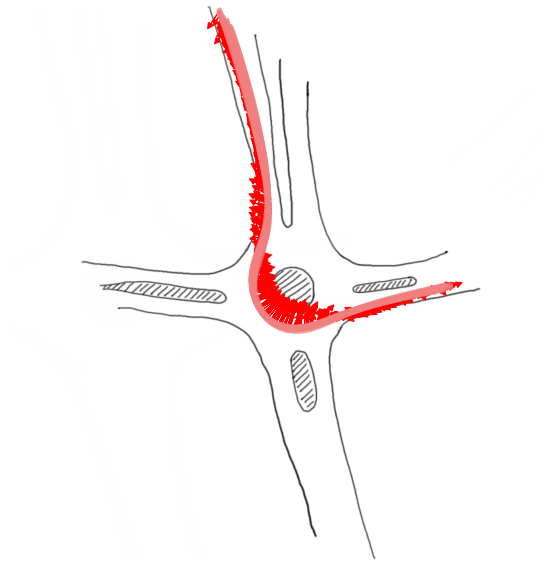

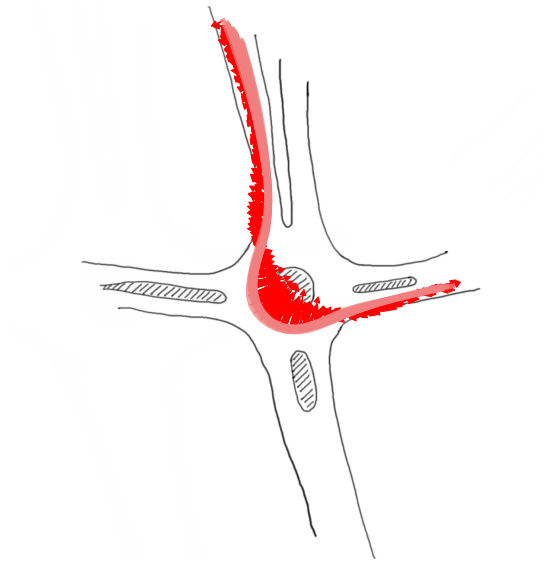

In [55]:
for node in tree.tree:
    _ = plot_trajectories_acc(tracks, node.idx_obs, node.labels, trackId, 
                              background, meta, sdf=10, skip_frame=10)
    plt.savefig(f'./figures/tree/acc/node-{node.identifier}.png', bbox_inches='tight', format='png')

In [134]:
def plot_eigenfunctions(basis, idx):
    """
    This methods plots eigenfunctions
    :param node: a node of the tree
    :param idx: the indices to plot
    :return: matplotlib figure
    """
    fig, axs = plt.subplots(1, 6, figsize=(15, 5))
    
        
    argvals = basis[0][idx].argvals['input_dim_0']
        
    axs[0].plot(argvals, basis[0][idx].values[0])
    axs[1].plot(argvals, basis[1][idx].values[0])
    axs[2].plot(argvals, basis[2][idx].values[0])
    axs[3].plot(argvals, basis[3][idx].values[0])
    axs[4].plot(argvals, basis[4][idx].values[0])
    axs[5].plot(argvals, basis[5][idx].values[0])
    
    axs[0].set_title('Longitudinal Position')
    axs[0].set_xlabel('Normalized time')
    axs[0].set_ylabel(fr'$\varphi_{idx+1}$')
    
    axs[1].set_title('Lateral Position')
    axs[1].set_xlabel('Normalized time')
    axs[1].set_ylabel(fr'$\varphi_{idx+1}$')
    
    axs[2].set_title('Longitudinal Velocity')
    axs[2].set_xlabel('Normalized time')
    axs[2].set_ylabel(fr'$\varphi_{idx+1}$')
    
    axs[3].set_title('Lateral Velocity')
    axs[3].set_xlabel('Normalized time')
    axs[3].set_ylabel(fr'$\varphi_{idx+1}$')
    
    axs[4].set_title('Longitudinal Acceleration')
    axs[4].set_xlabel('Normalized time')
    axs[4].set_ylabel(fr'$\varphi_{idx+1}$')
    
    axs[5].set_title('Lateral Acceleration')
    axs[5].set_xlabel('Normalized time')
    axs[5].set_ylabel(fr'$\varphi_{idx+1}$')
    
    fig.tight_layout()
    return fig, axs

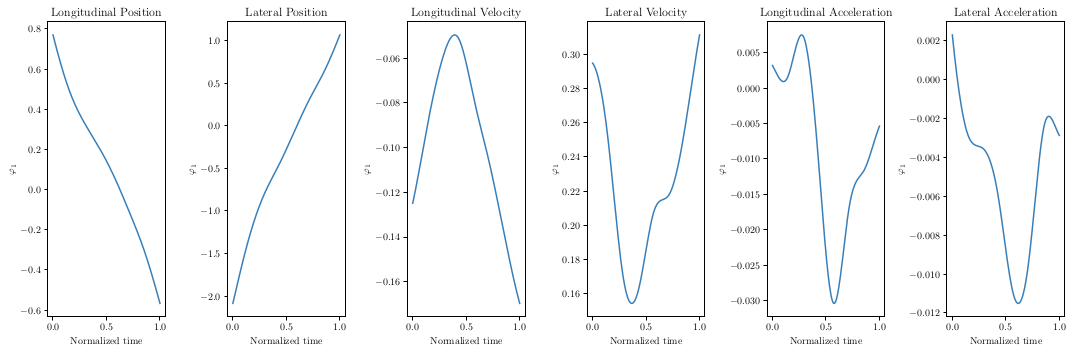

In [135]:
_ = plot_eigenfunctions(tree.tree[0].fpca.basis, 0)
plt.savefig(f'./figures/tree/node0-eigenfunction_1.eps', bbox_inches='tight', format='eps')

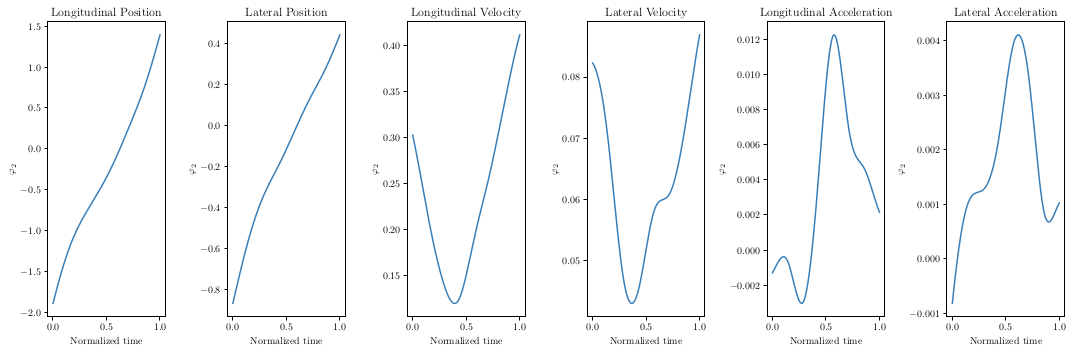

In [136]:
_ = plot_eigenfunctions(tree.tree[0].fpca.basis, 1)
plt.savefig(f'./figures/tree/node0-eigenfunction_2.eps', bbox_inches='tight', format='eps')

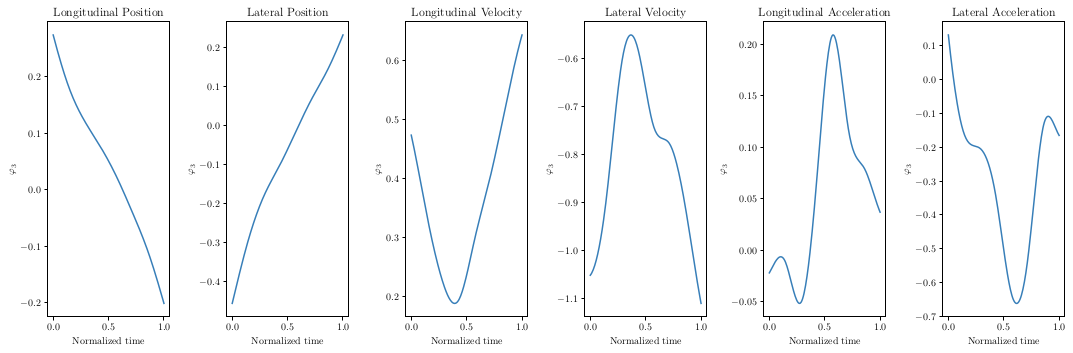

In [137]:
_ = plot_eigenfunctions(tree.tree[0].fpca.basis, 2)
plt.savefig(f'./figures/tree/node0-eigenfunction_3.eps', bbox_inches='tight', format='eps')

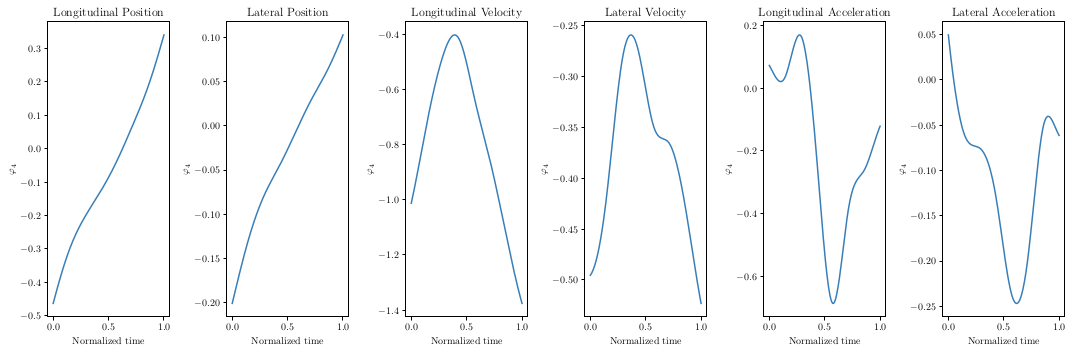

In [138]:
_ = plot_eigenfunctions(tree.tree[0].fpca.basis, 3)
plt.savefig(f'./figures/tree/node0-eigenfunction_4.eps', bbox_inches='tight', format='eps')

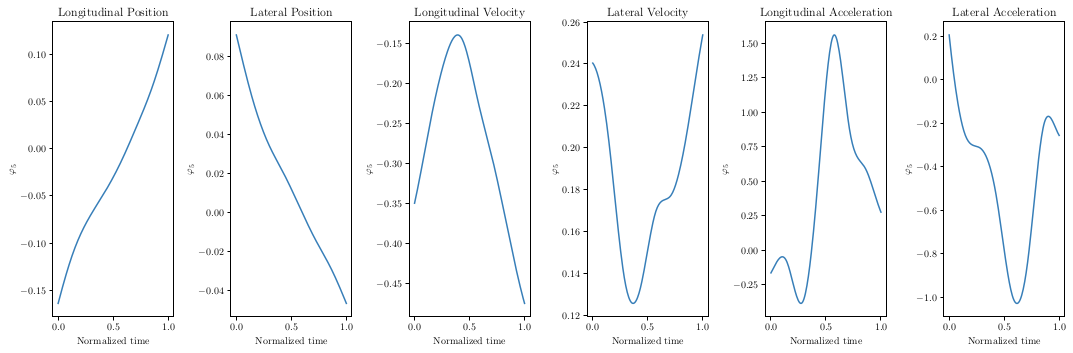

In [139]:
_ = plot_eigenfunctions(tree.tree[0].fpca.basis, 4)
plt.savefig(f'./figures/tree/node0-eigenfunction_5.eps', bbox_inches='tight', format='eps')

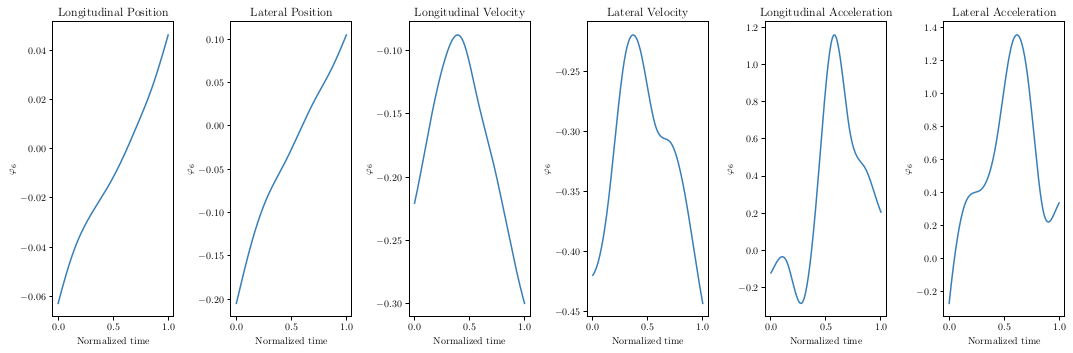

In [140]:
_ = plot_eigenfunctions(tree.tree[0].fpca.basis, 5)
plt.savefig(f'./figures/tree/node0-eigenfunction_6.eps', bbox_inches='tight', format='eps')